In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2024-01-22 08:46:20.966621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [100]:
model_name = 'enformer'
data_dir = '../data/'
test_results = f'../results/distance_test_True/{model_name}/'

In [101]:
tile_coords = pd.read_csv(f'../results/summary_csvs/enformer/sufficiency_test_tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000

In [102]:
cre_df = pd.read_csv(f'../results/summary_csvs/enformer/sufficient_CREs.csv')


In [103]:
cre_df.groupby(['cell_line', 'context', 'tile class']).count()['seq_id']

cell_line  context    tile class
GM12878    enhancing  Enhancer       41
           silencing  Silencer       57
K562       enhancing  Enhancer       74
           silencing  Silencer      222
PC-3       enhancing  Enhancer       35
           silencing  Silencer       97
Name: seq_id, dtype: int64

In [104]:
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


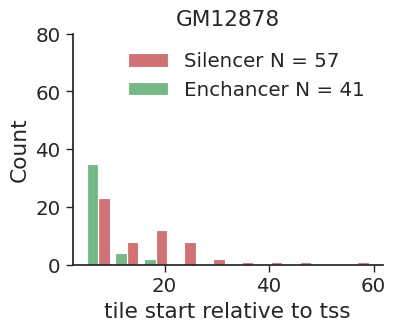

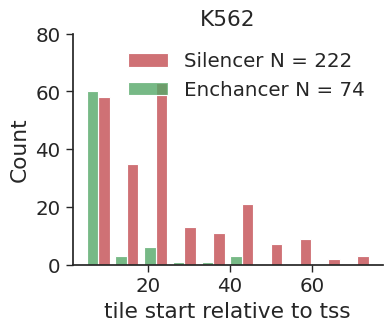

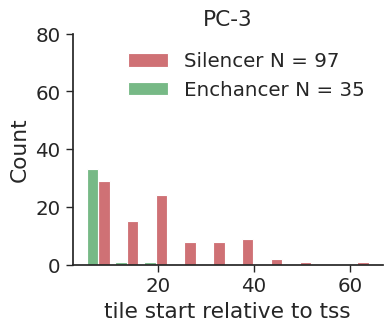

In [105]:

sns.set(font_scale = 1.3)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[4,3])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False)
    plt.title(cell)
    plt.show()

In [106]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'{data_dir}/{model_name}_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
cell_lines

['PC-3', 'GM12878', 'K562']

In [111]:
result_normalized_effects = []
all_norm_effects = []
raw_preds = {}
for i, cell_line in enumerate(cell_lines):
    raw_preds[cell_line] = []
    cre_df_cell = cre_df[cre_df['cell_line'] == cell_line]
    cre_df_cell.insert(1, "distance to TSS (Kb)", [np.abs(int(i) - tss_tile[0]) // 1000 for i in cre_df_cell['tile_start'].values ])
    for j, (_, row) in tqdm(enumerate(cre_df_cell.iterrows())):
        tile_start, tile_end = [row['tile_start'], row['tile_end']]
        result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
        res = utils.read_pickle(result_path)
        control = res['mean_control'][447:449,i].mean()
        test = res['mean_mut'][:, 447:449, i].mean(axis=-1)
        # norm_effects = test / control
        norm_effects = test / np.max(test)
        all_norm_effects.append(norm_effects)
        df = pd.DataFrame([norm_effects, cre_tiles_starts_abs]).T
        df.columns = ['Fold change over control', 'Binned distance (Kb)']
        df['Normalized CRE effect (control)'] = row['Normalized CRE effect']
        raw_preds[cell_line].append(test)
        df['cell line'] = cell_line
        df['control'] = control
        df['enf_data_id'] = f'{row["seq_id"]}_{tile_start}_{tile_end}'
        df['context'] = row['context']
        df['tile class'] = row['tile class']
        result_normalized_effects.append(df)
result_normalized_effects = pd.concat(result_normalized_effects)

132it [00:00, 690.08it/s]
98it [00:00, 693.38it/s]
296it [00:00, 692.44it/s]


In [112]:
result_normalized_effects.head(2)


Fold change over control  Binned distance (Kb)   
0                  0.101222                  95.0  \
1                  0.105104                  90.0   

   Normalized CRE effect (control) cell line    control   
0                         0.377385      PC-3  45.395157  \
1                         0.377385      PC-3  45.395157   

                           enf_data_id    context tile class  
0  SQOR_chr15_45635028_+_100804_105804  enhancing   Enhancer  
1  SQOR_chr15_45635028_+_100804_105804  enhancing   Enhancer

In [109]:
# my_palette = {}
# tile_labels = {}
# for i, row in n_df.iterrows():
#     c = 'g' if i=='Enhancer' else 'r'
#     my_palette[f'{i} N={row.iloc[0]}'] = c
#     k = 'Enhancer' if 'Enh' in k else 'Silencer'
#     tile_labels[k] = f'{i} N={row.iloc[0]}'

In [ ]:
for cell_line, df in result_normalized_effects.groupby('cell line'):
#     df = pd.concat([df[(df['context']=='silencing') & (df['tile class']=='Enhancer')],
#                     df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
# ])
#     df = pd.concat([df[(df['context']=='enhancing') & (df['tile class']=='Enhancer')], df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
# ])
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//38}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//38}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    ax=sns.lineplot(data=df, x='Binned distance (Kb)', y='Fold change over control', hue='tile class', ci='sd',
              palette=my_palette)
    ax.plot([1,93],[1,1], '--k')
    ax.set_xlim([5,100])
    # ax.set_ylim(0,1.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)

    plt.legend(frameon=False, bbox_to_anchor=[1.5,1])
    plt.show()

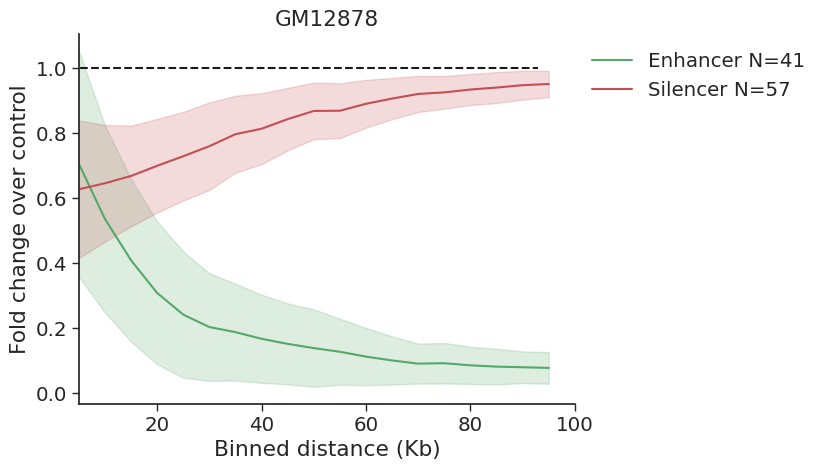

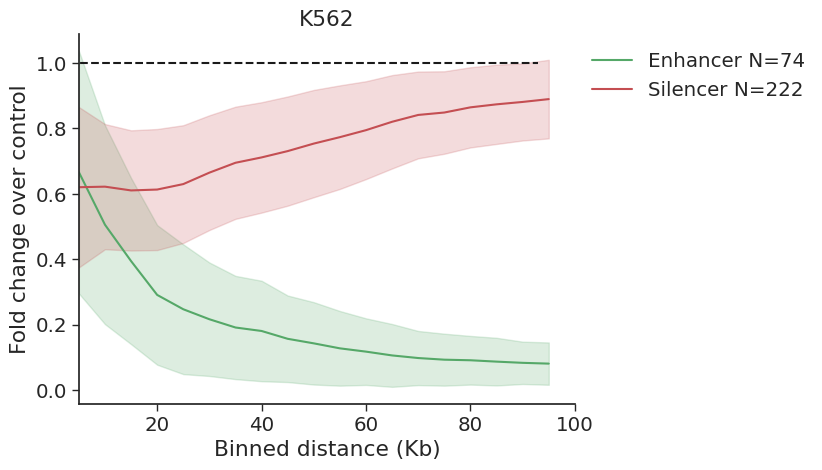

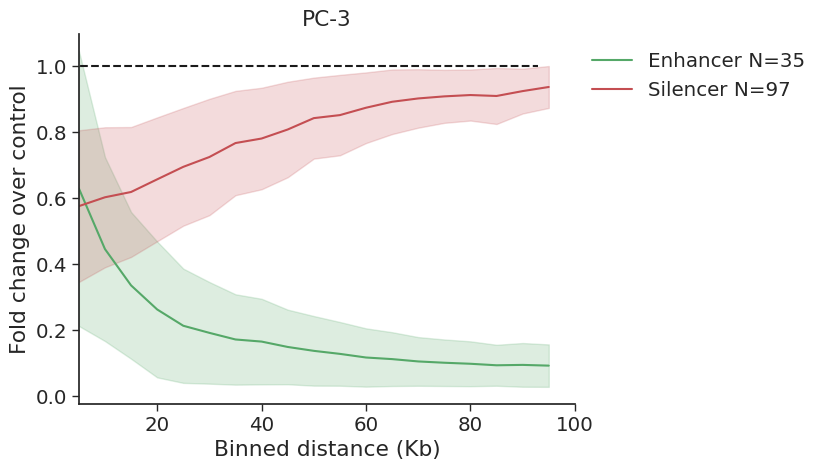

In [110]:
for cell_line, df in result_normalized_effects.groupby('cell line'):
#     df = pd.concat([df[(df['context']=='silencing') & (df['tile class']=='Enhancer')],
#                     df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
# ])
#     df = pd.concat([df[(df['context']=='enhancing') & (df['tile class']=='Enhancer')], df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
# ])
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//38}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//38}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    ax=sns.lineplot(data=df, x='Binned distance (Kb)', y='Fold change over control', hue='tile class', ci='sd',
              palette=my_palette)
    ax.plot([1,93],[1,1], '--k')
    ax.set_xlim([5,100])
    # ax.set_ylim(0,1.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)

    plt.legend(frameon=False, bbox_to_anchor=[1.5,1])
    plt.show()

In [114]:
result_normalized_effects.to_csv('../results/summary_csvs/enformer/distance_test.csv')

# Borzoi

In [15]:
enformer_model_seq_length = 196608
borzoi_model_seq_length = 524288
delta_seq_length = (borzoi_model_seq_length - enformer_model_seq_length) // 2

In [12]:
cre_df = pd.read_csv(f'../results/summary_csvs/enformer/sufficient_CREs.csv')


In [31]:
tss_tile, cre_tiles = utils.set_tile_range(borzoi_model_seq_length, 5000)

cre_tiles_starts = np.array(cre_tiles).T[0]
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000

In [14]:
model_name = 'borzoi'
data_dir = '../data/'
test_results = f'../results/distance_test_True/{model_name}/'

In [16]:
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
cell_lines_for_search = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
track_index = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in cell_lines_for_search)]
cell_line_info = {}
for target_cell_line in cell_lines_for_search:
    
    
    targets = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() == target_cell_line)]
    
    target_cell_line = target_cell_line.split()[0]
    cell_line_info[target_cell_line] = {}
    cell_line_info[target_cell_line]['output'] = [np.argwhere(np.array(track_index) == t).flatten()[0] for t in
                                                  targets]
    cell_line_info[target_cell_line]['target'] = '&'.join([str(t) for t in targets])

In [67]:
wt = utils.read_pickle(f'../results/gencode_tss_predictions/borzoi/{row["seq_id"]}.pickle')['cage'][0, :, track_output_index].mean()


0.2108

In [103]:
tile_start

264644

In [116]:
test.shape

(102,)

0it [00:00, ?it/s]

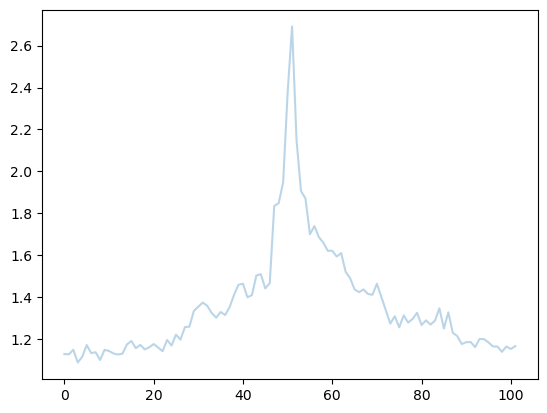

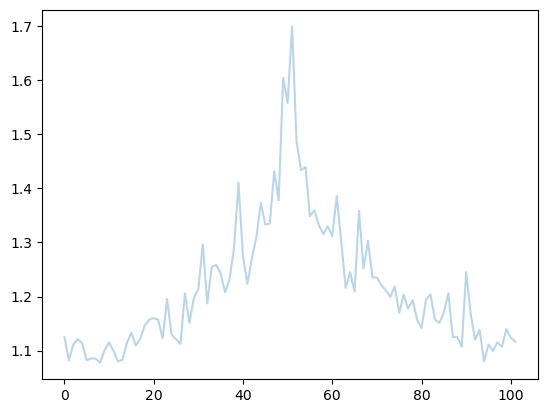

2it [00:00, 12.09it/s]

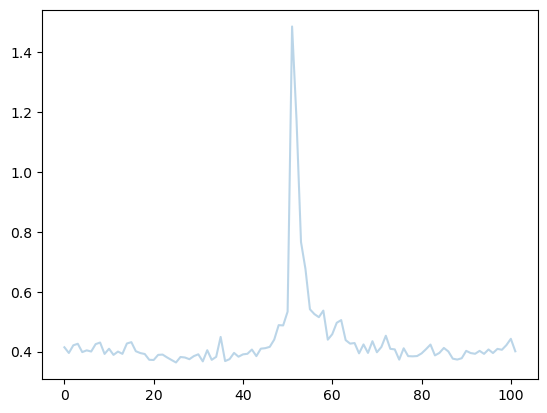

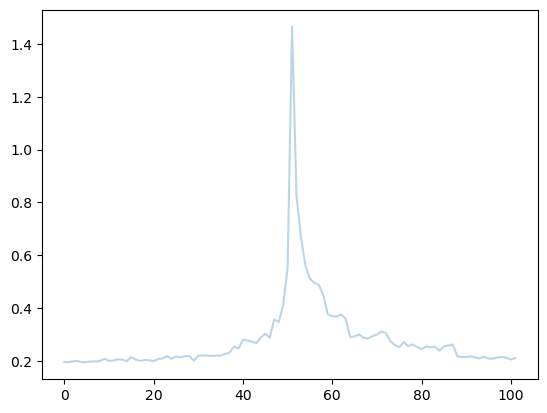

4it [00:00, 12.40it/s]

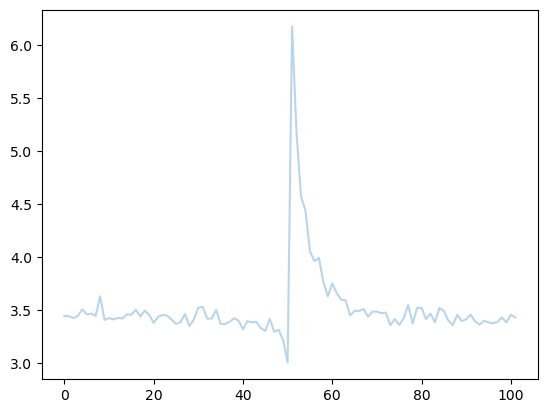

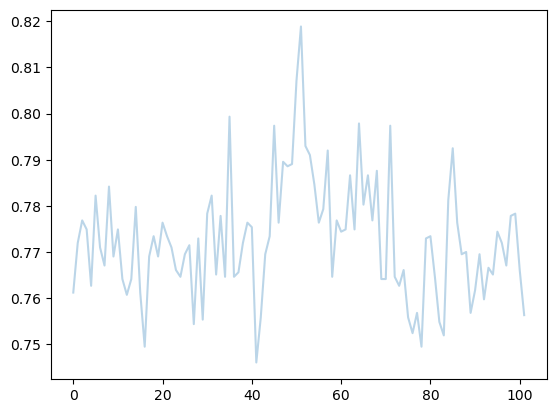

6it [00:00, 12.27it/s]

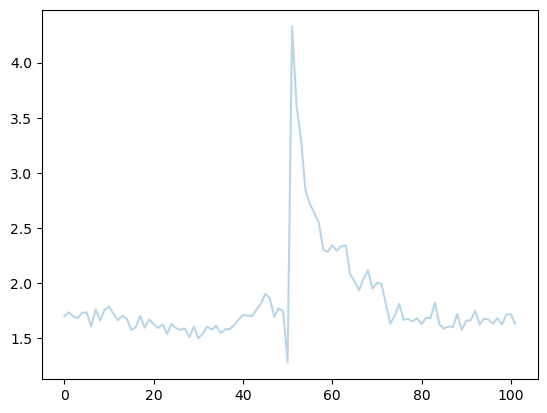

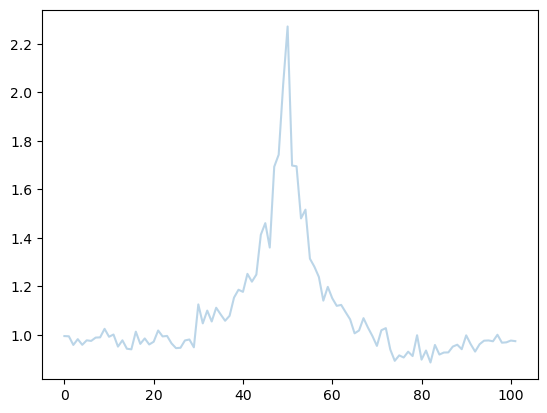

8it [00:00, 12.40it/s]

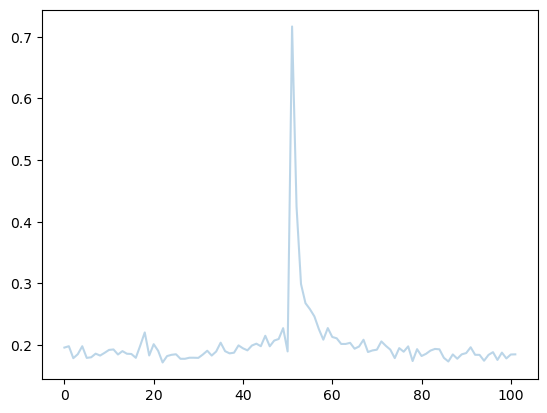

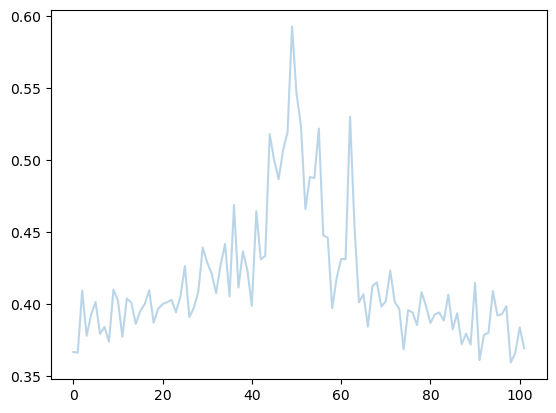

10it [00:00, 12.50it/s]

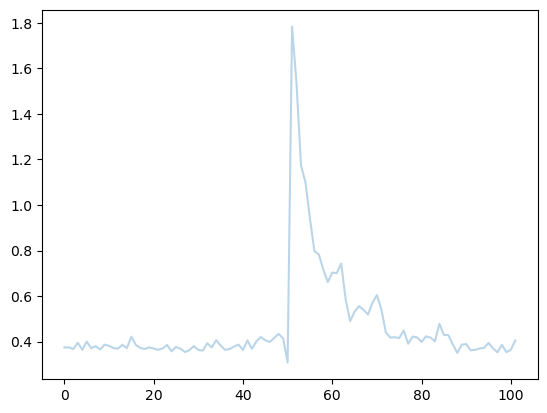

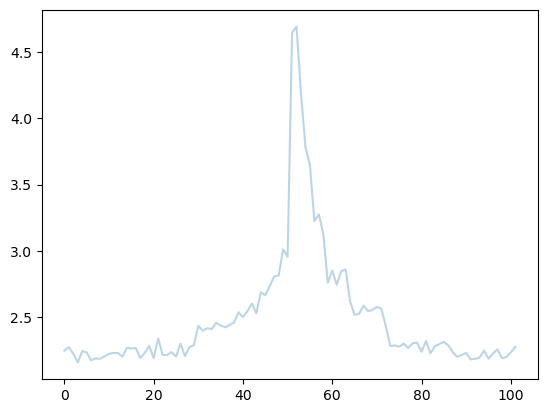

12it [00:00, 12.55it/s]

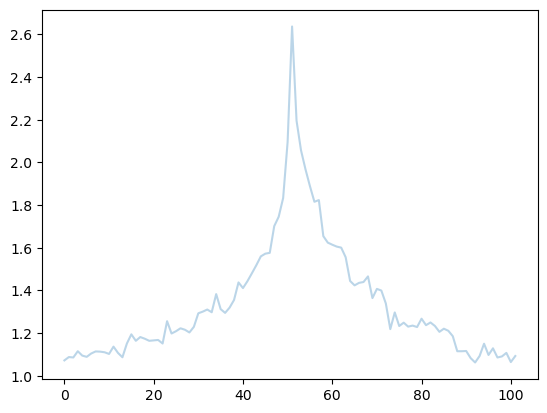

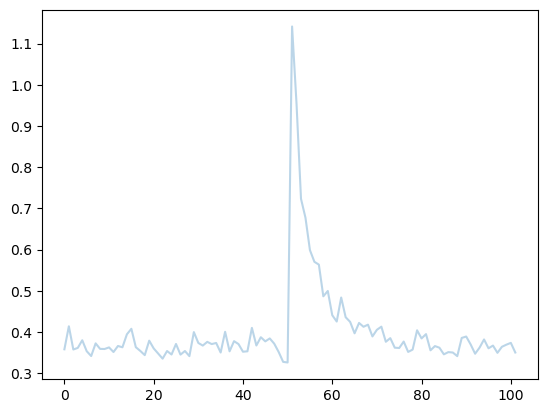

14it [00:01, 12.26it/s]

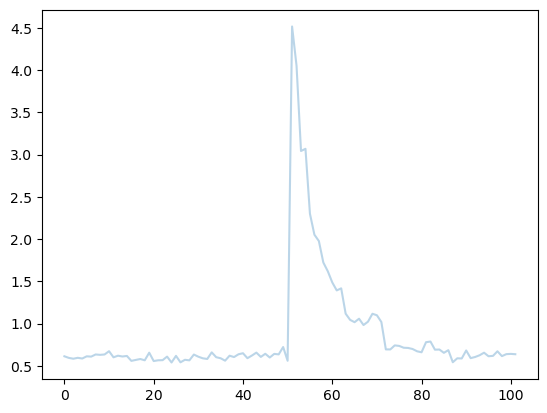

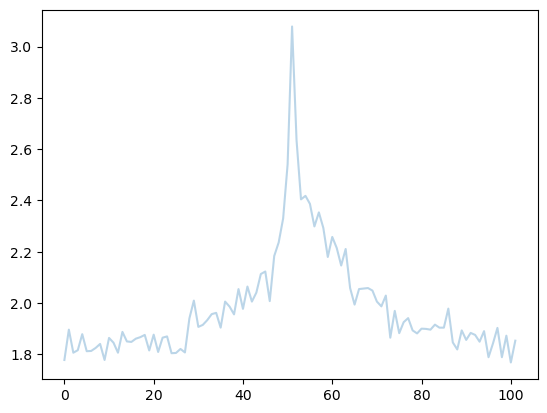

16it [00:01, 12.19it/s]

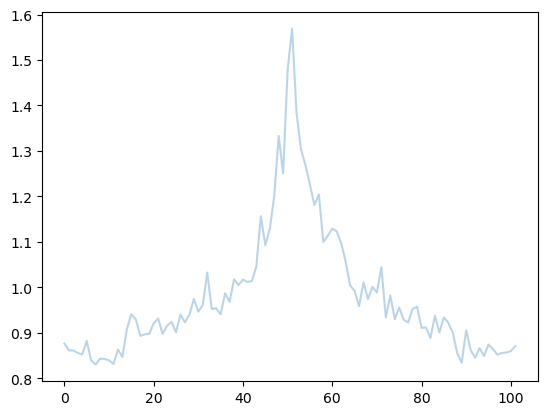

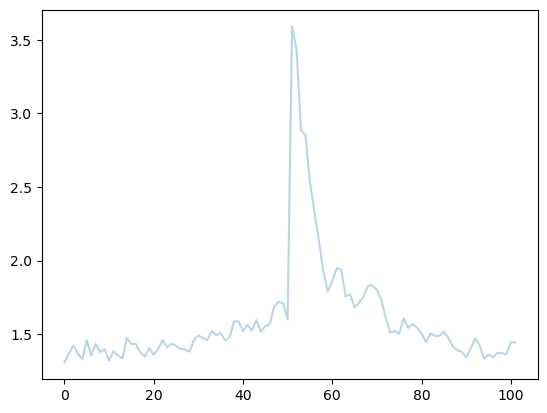

18it [00:01, 12.27it/s]

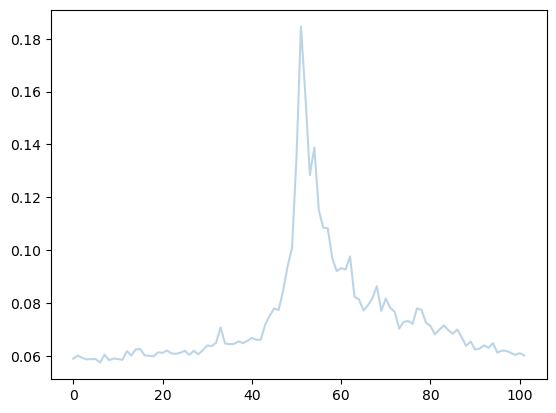

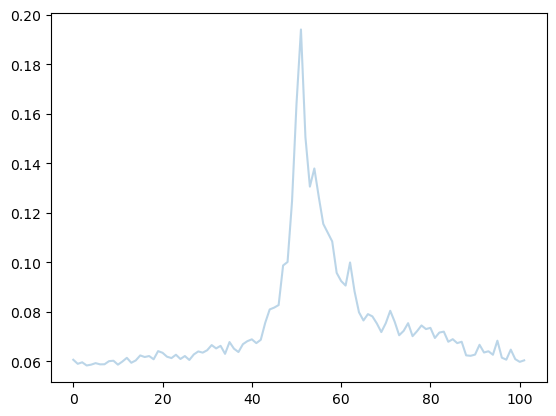

20it [00:01, 12.26it/s]

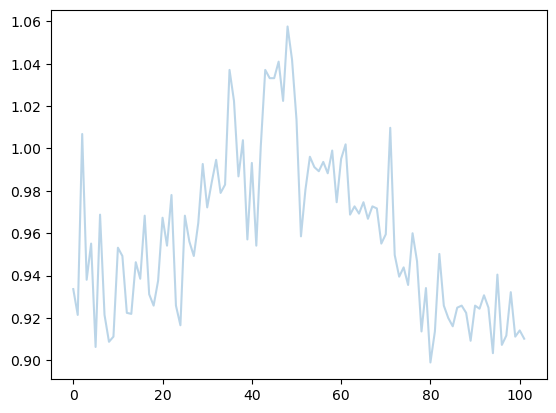

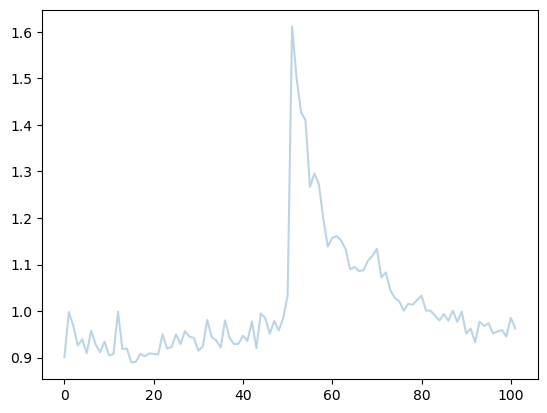

22it [00:01, 12.10it/s]

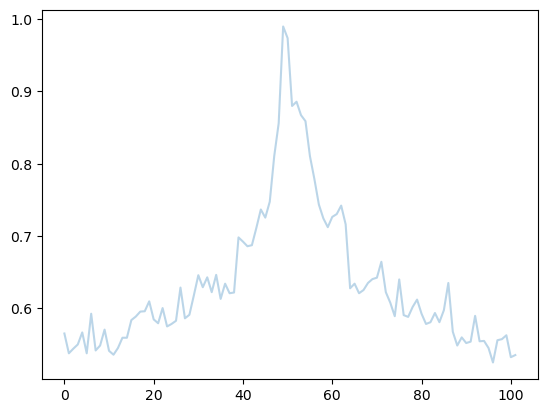

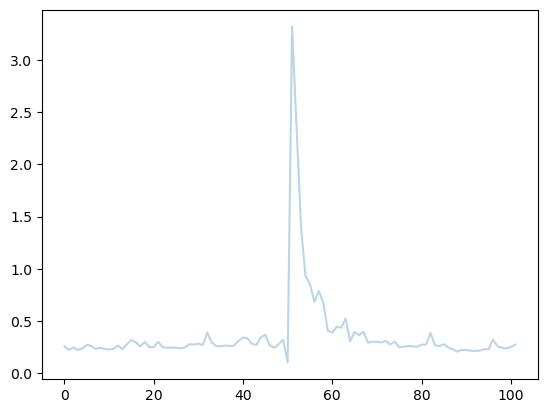

24it [00:01, 12.33it/s]

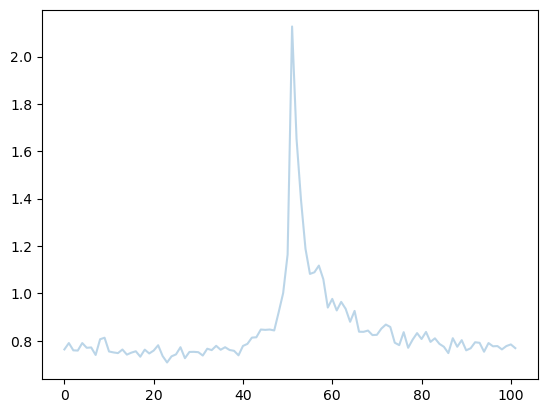

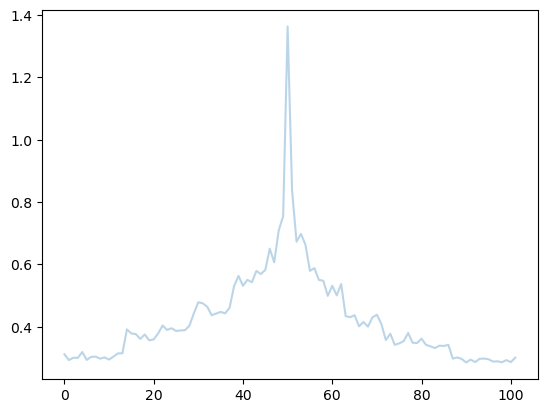

26it [00:02, 12.45it/s]

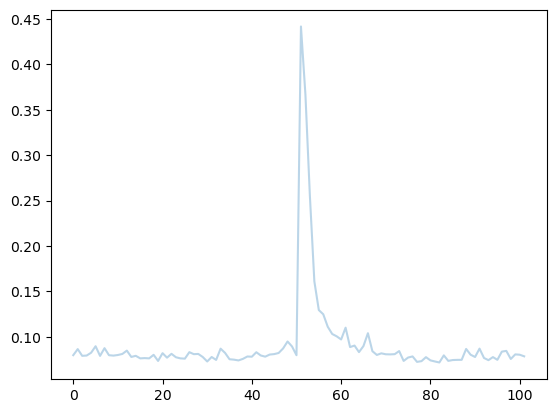

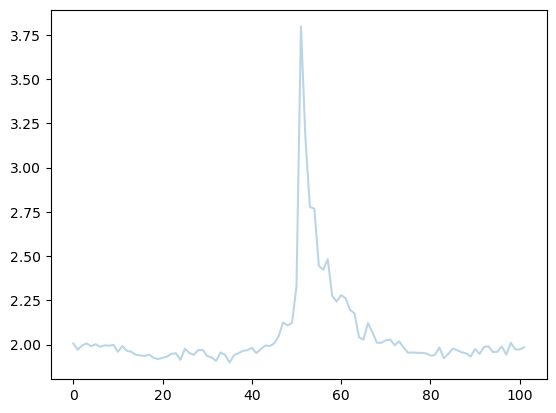

28it [00:02, 12.34it/s]

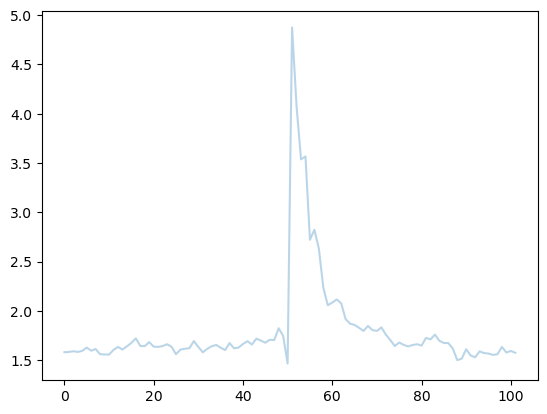

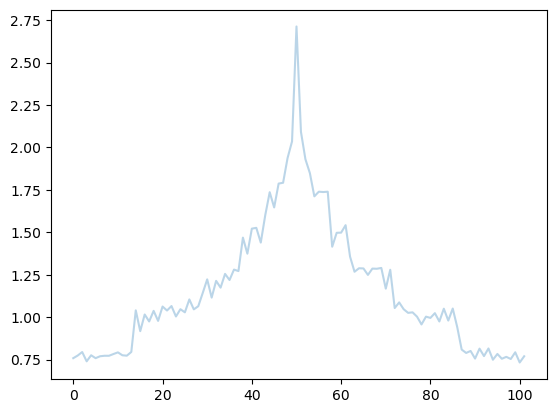

30it [00:02, 12.23it/s]

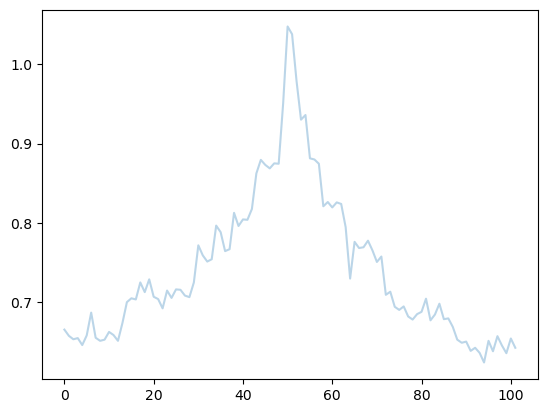

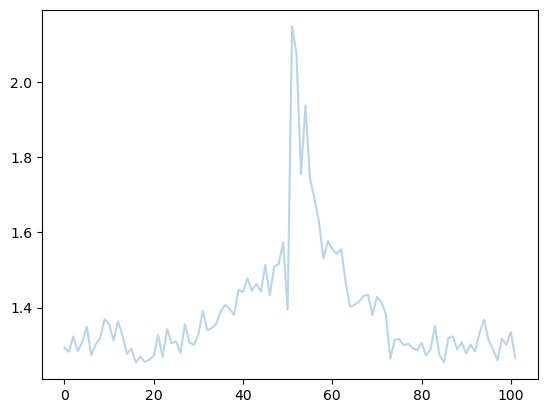

32it [00:02, 12.64it/s]

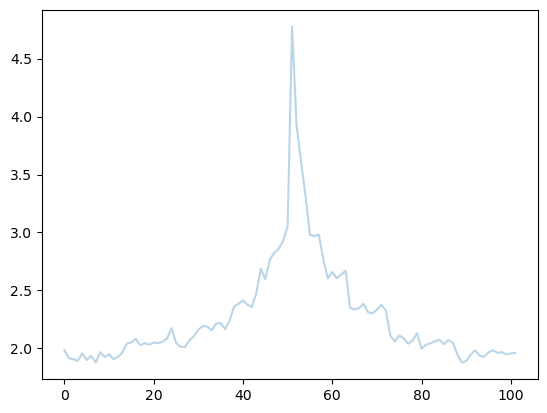

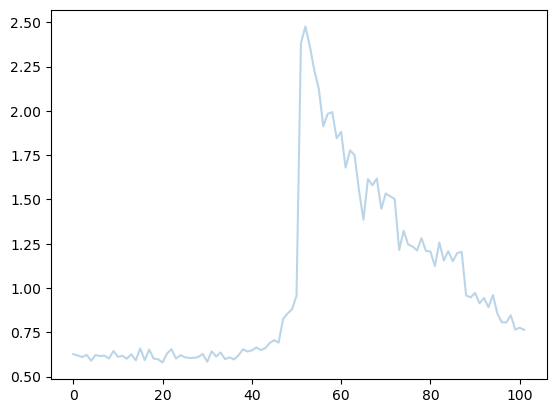

34it [00:02, 12.56it/s]

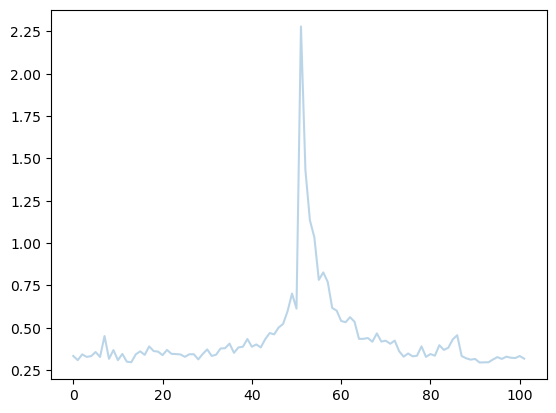

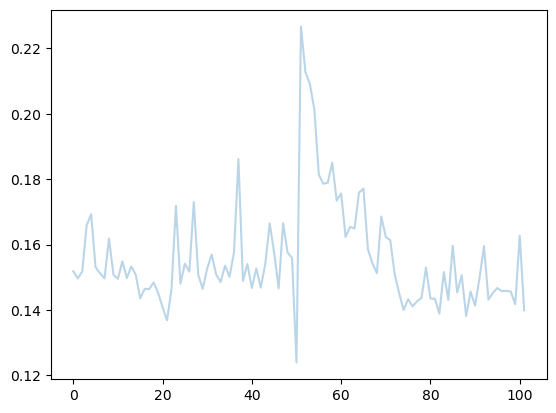

36it [00:02, 12.47it/s]

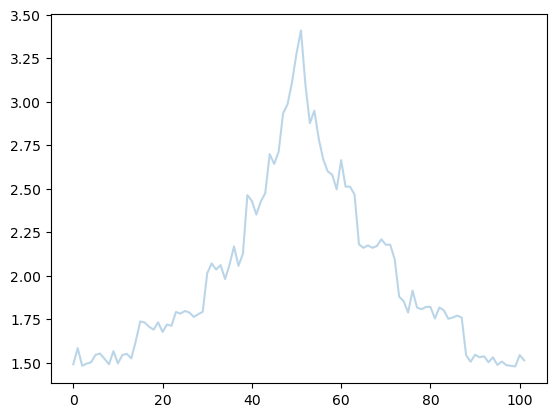

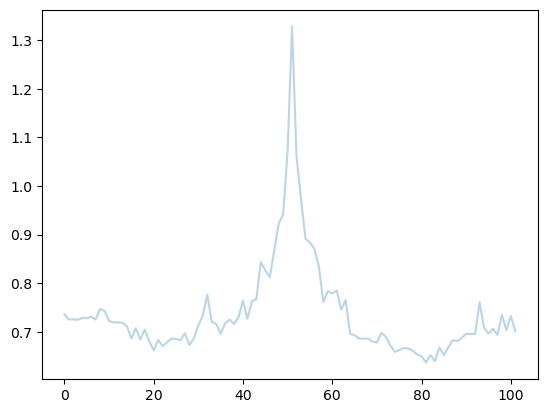

38it [00:03, 12.34it/s]

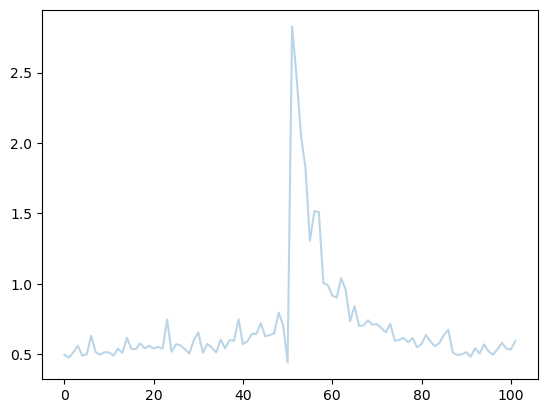

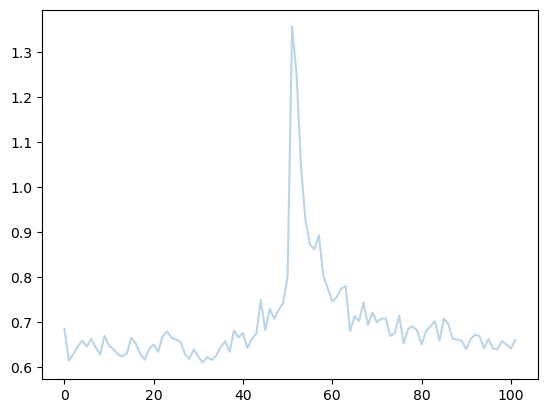

40it [00:03, 12.44it/s]

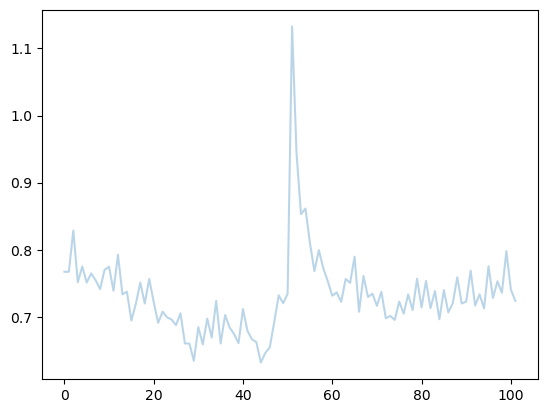

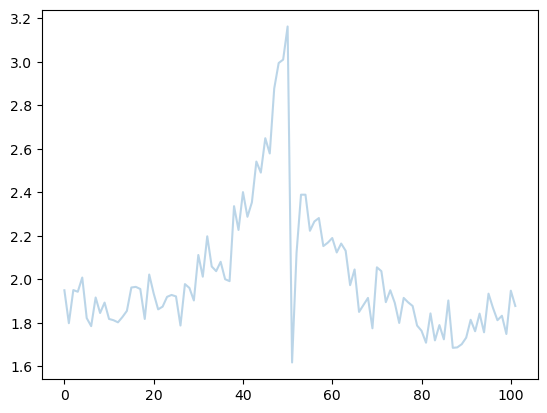

42it [00:03, 12.46it/s]

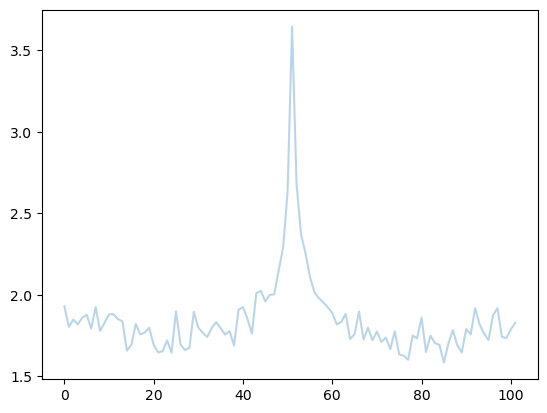

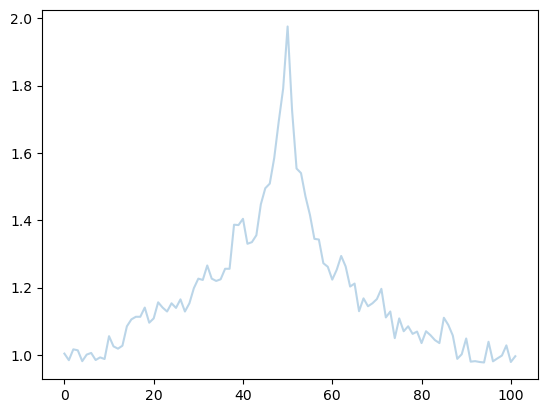

44it [00:03, 12.64it/s]

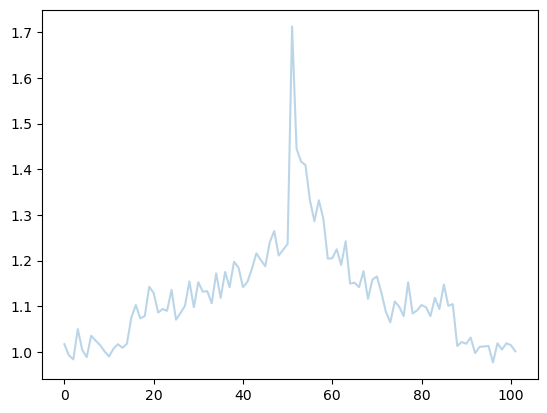

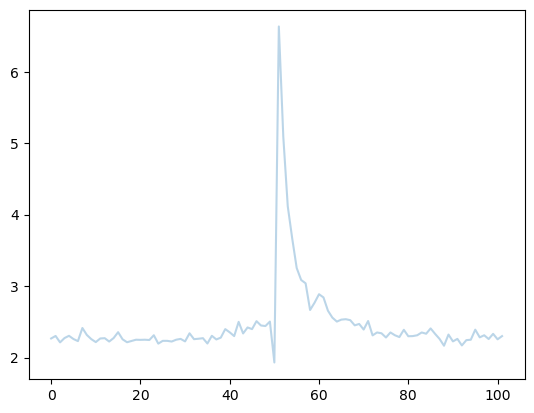

46it [00:03, 12.65it/s]

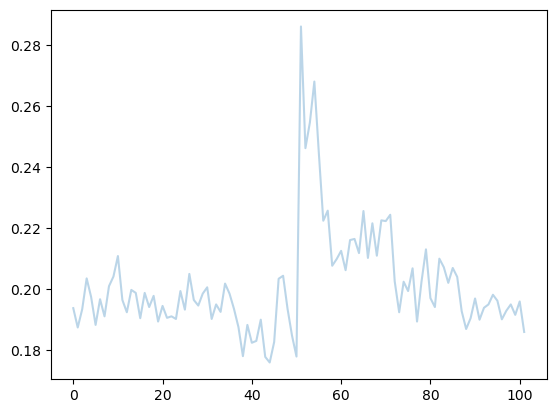

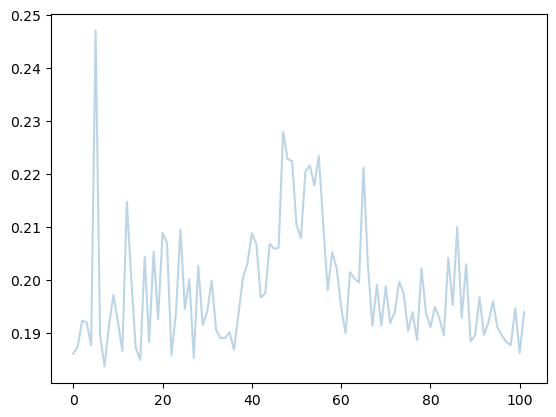

48it [00:03, 12.57it/s]

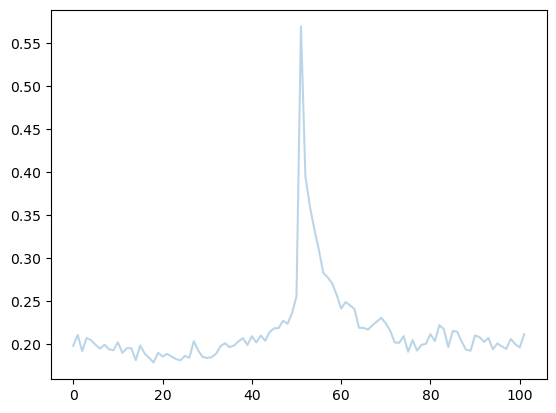

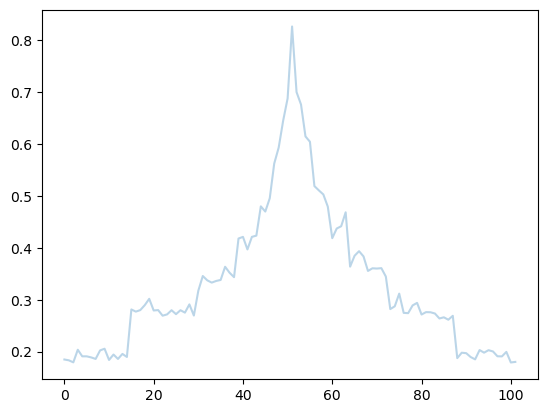

50it [00:04, 12.52it/s]

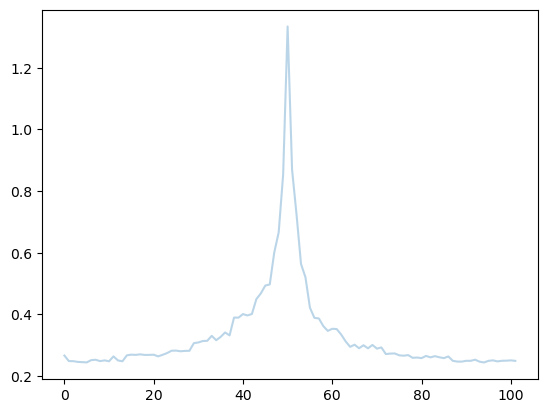

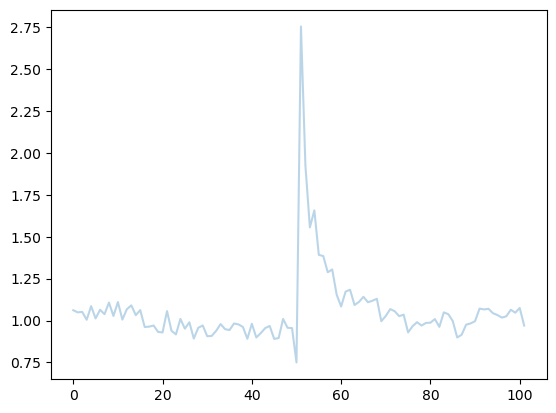

52it [00:04, 12.46it/s]

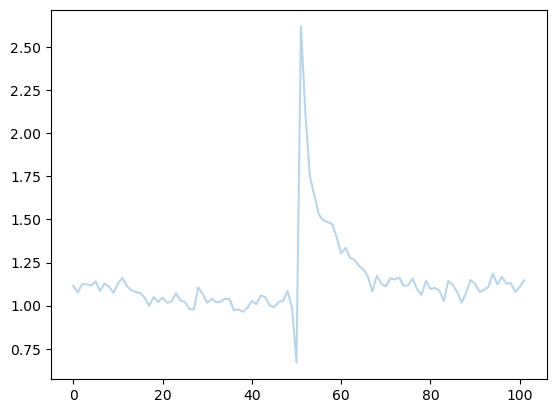

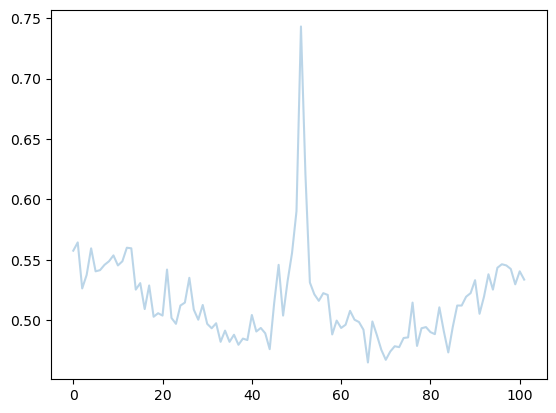

54it [00:04, 12.46it/s]

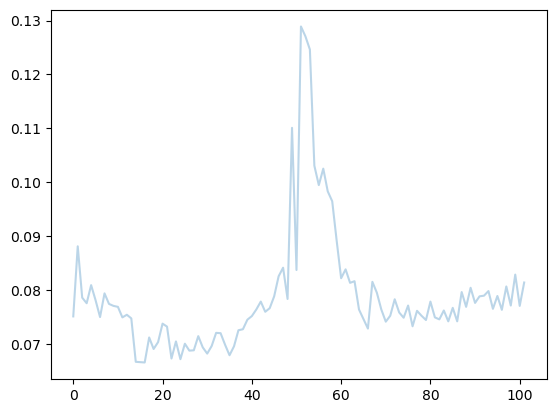

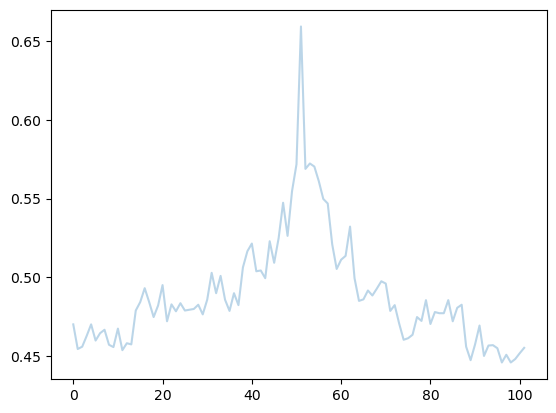

56it [00:04, 12.54it/s]

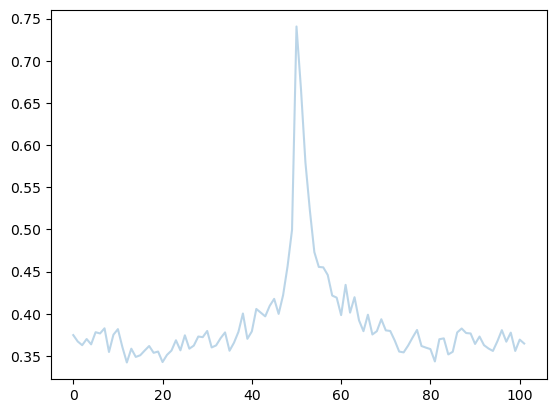

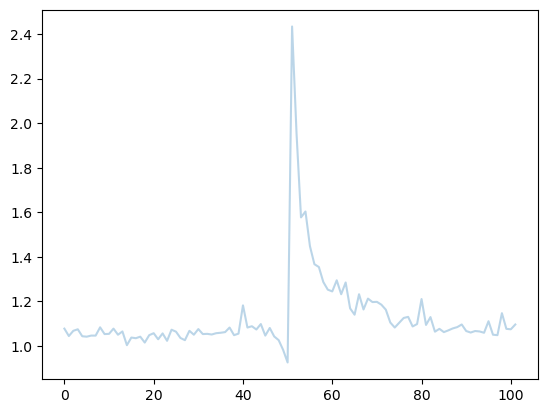

58it [00:04, 12.35it/s]

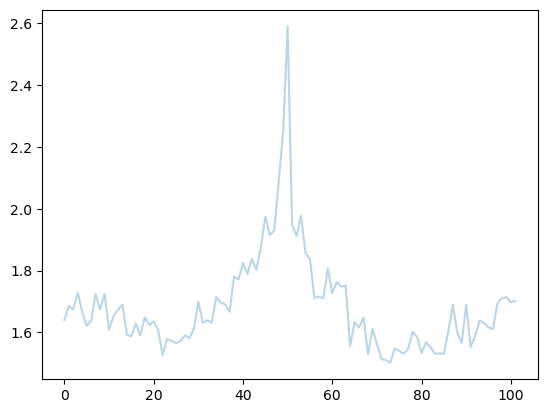

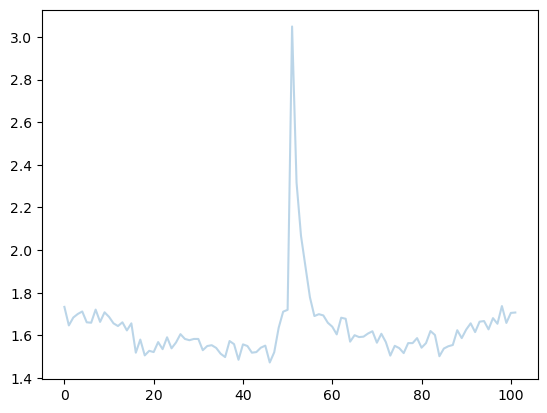

60it [00:04, 12.34it/s]

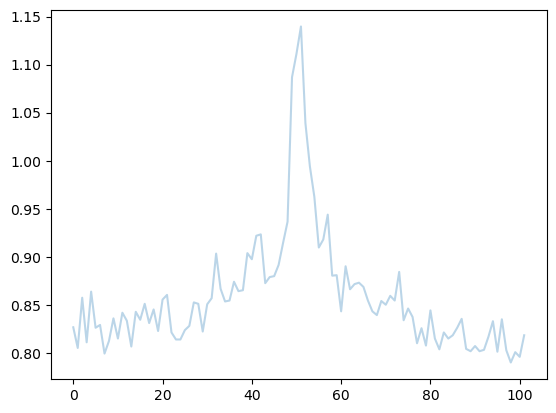

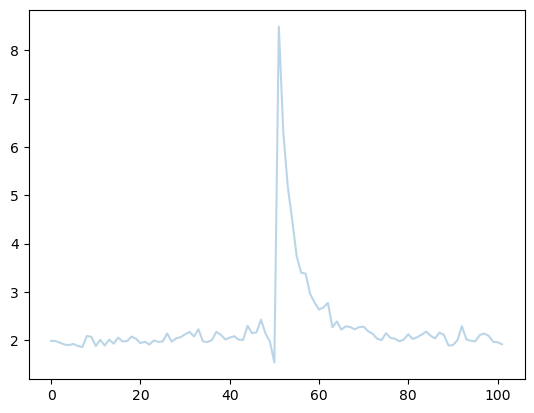

62it [00:04, 12.33it/s]

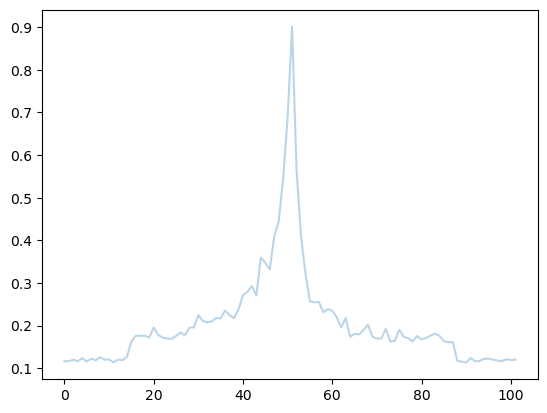

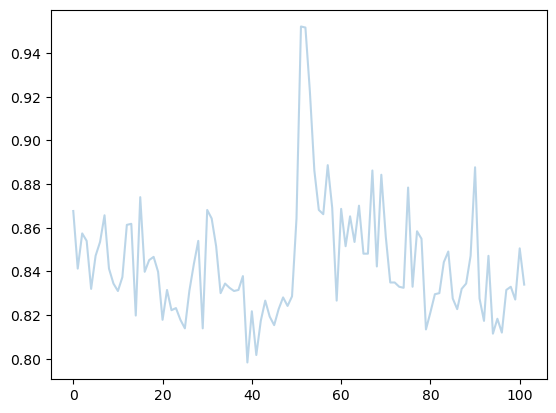

64it [00:05, 12.18it/s]

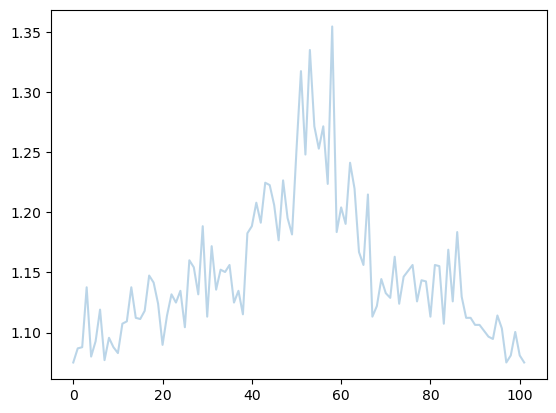

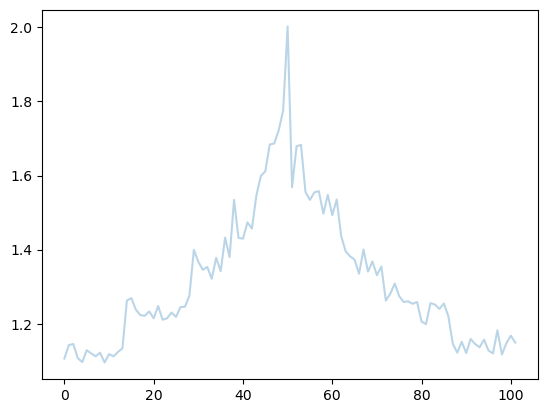

66it [00:05,  8.16it/s]

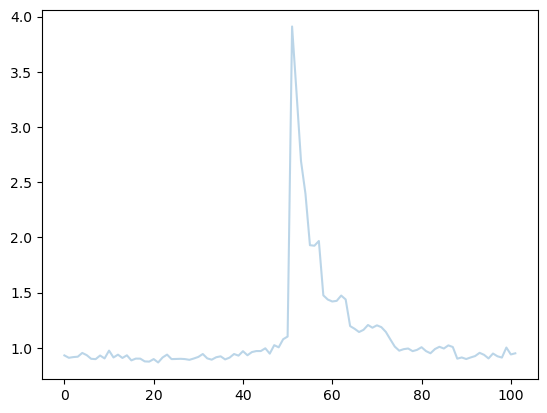

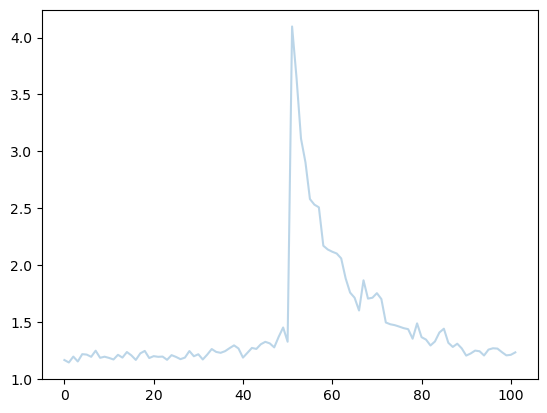

68it [00:05,  9.10it/s]

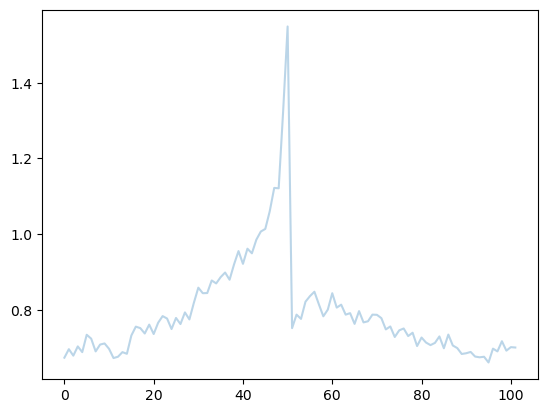

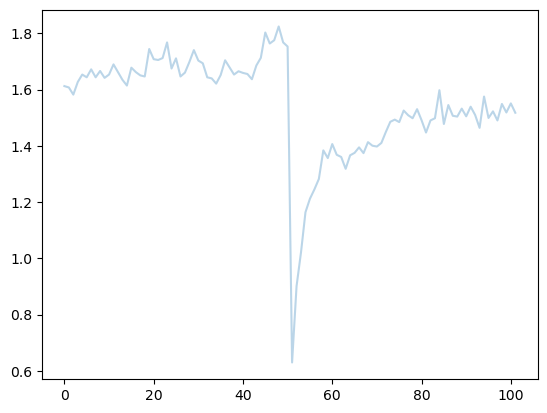

70it [00:05, 10.01it/s]

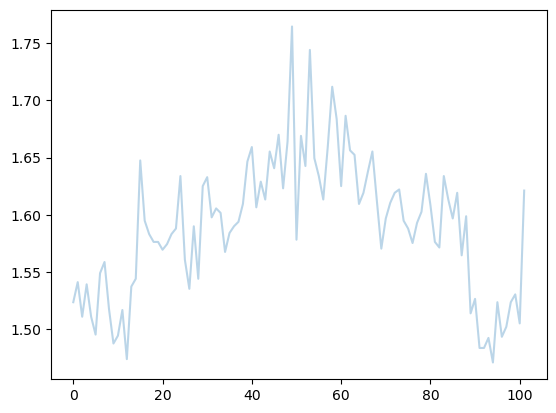

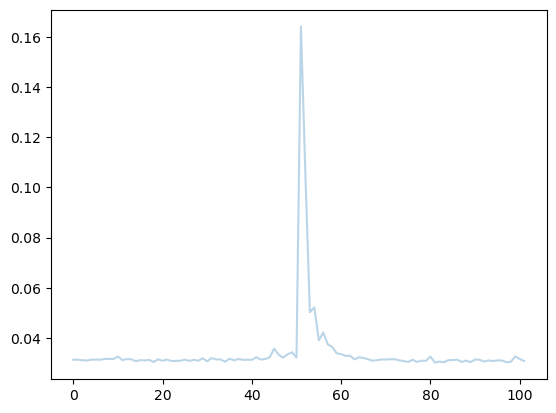

72it [00:06, 10.65it/s]

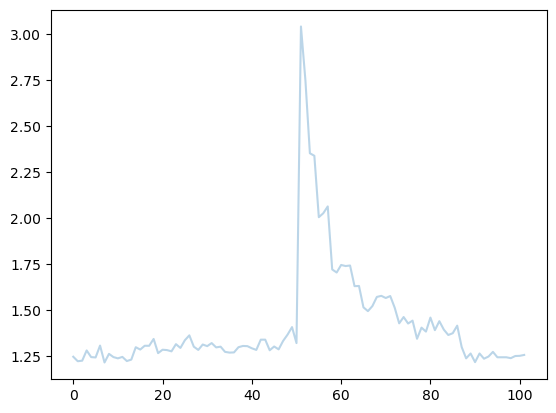

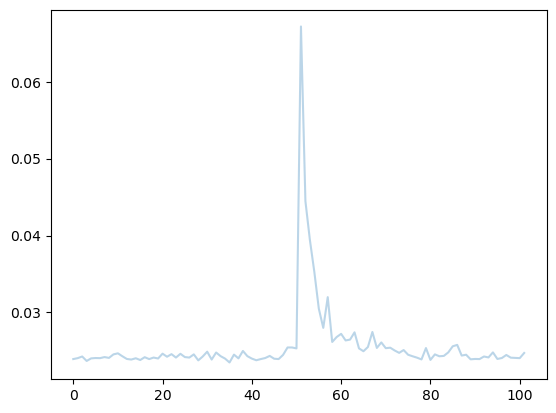

74it [00:06, 11.25it/s]

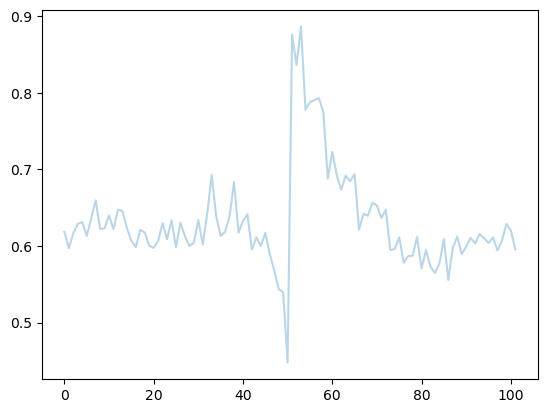

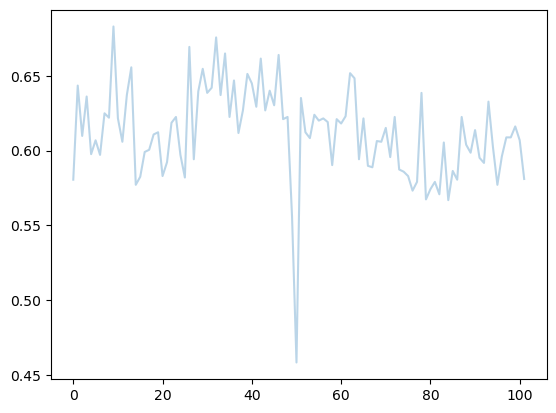

76it [00:06, 11.73it/s]

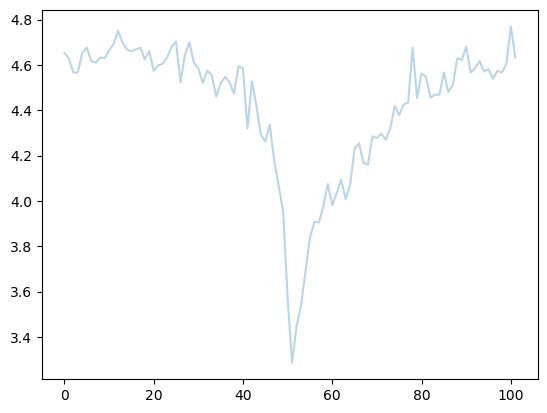

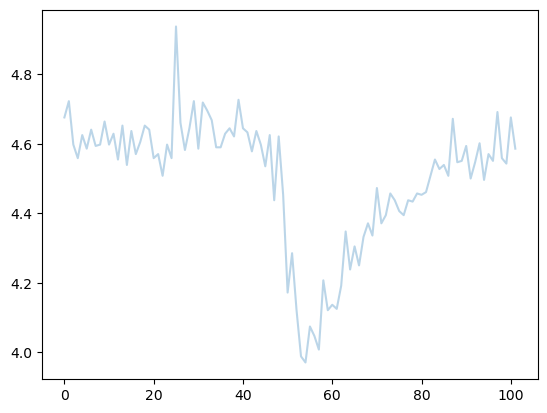

78it [00:06, 11.99it/s]

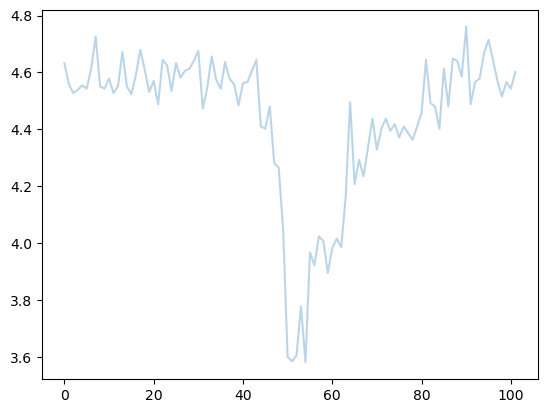

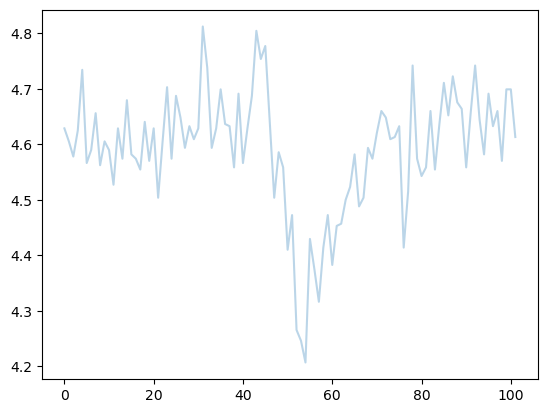

80it [00:06, 12.10it/s]

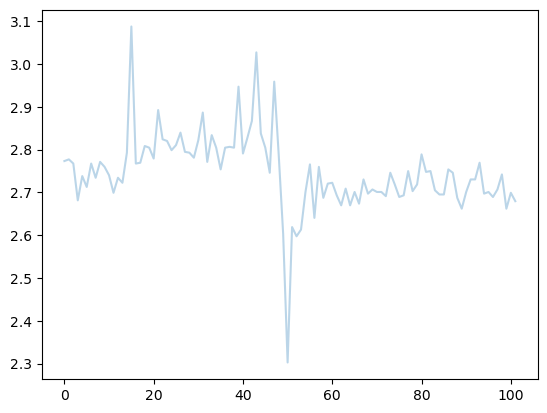

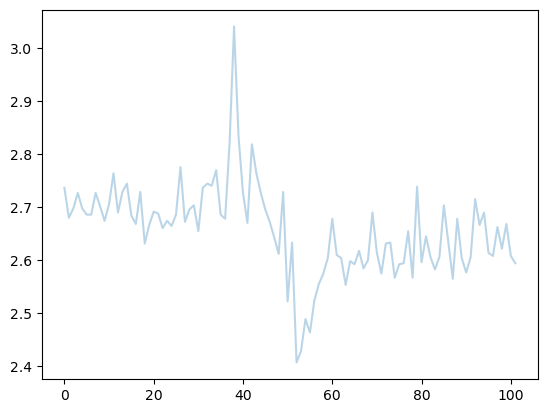

82it [00:06, 12.06it/s]

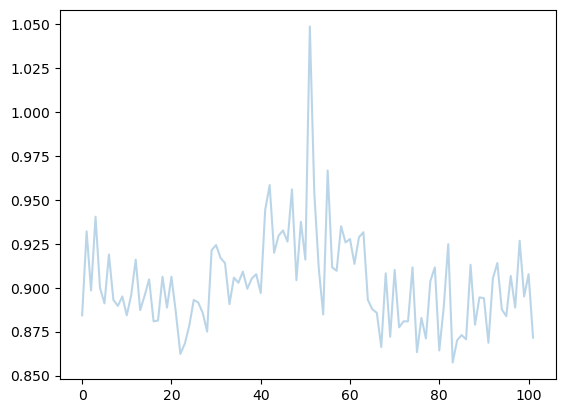

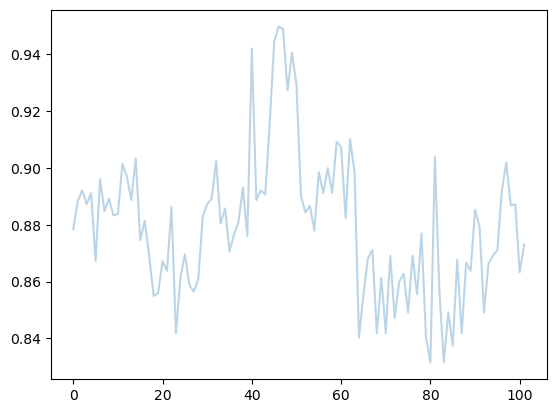

84it [00:07, 12.03it/s]

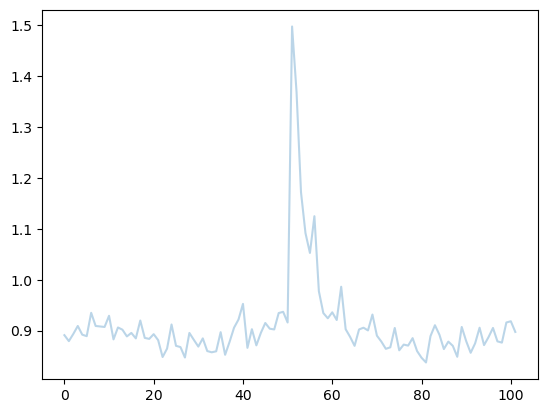

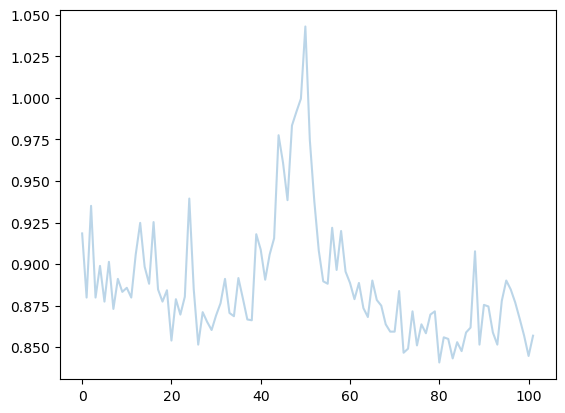

86it [00:07, 12.02it/s]

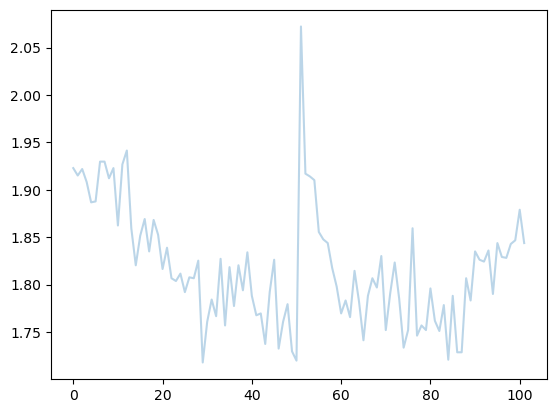

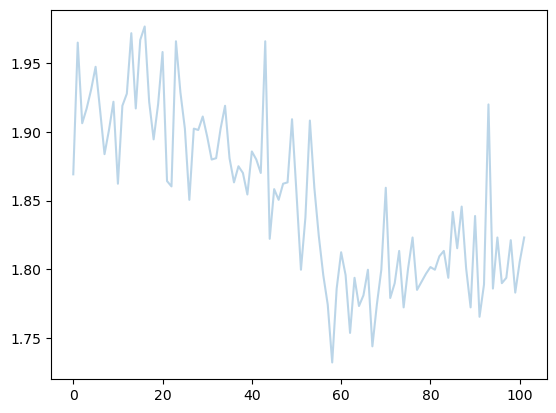

88it [00:07, 12.18it/s]

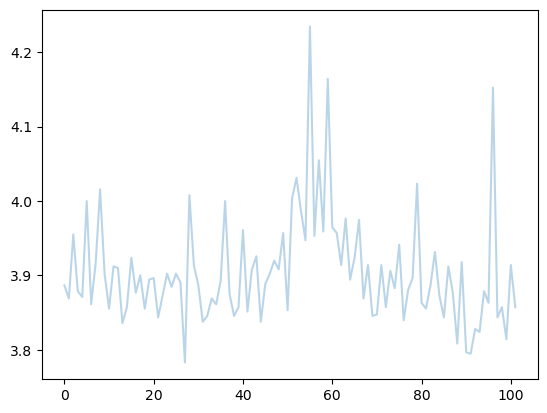

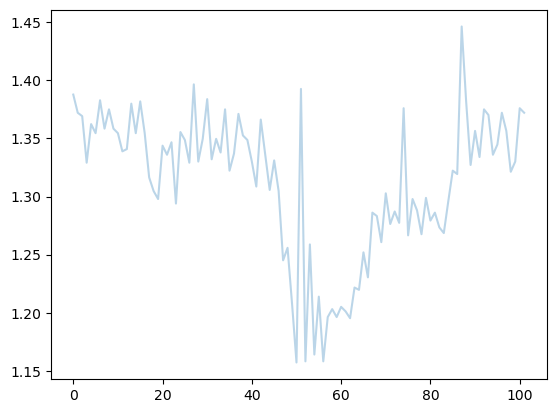

90it [00:07, 12.30it/s]

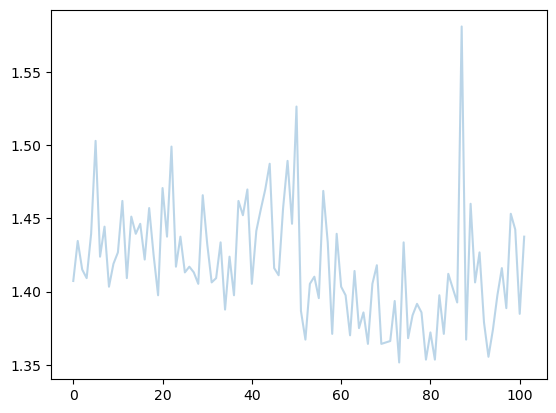

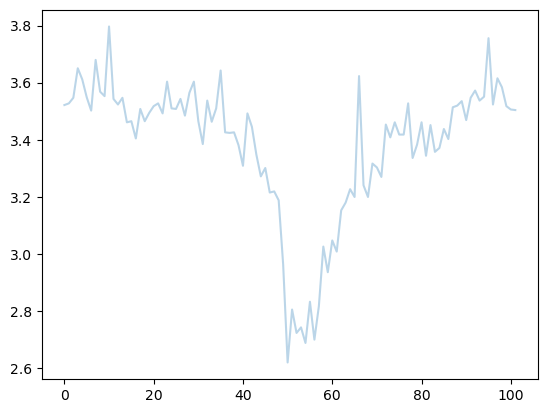

92it [00:07, 12.42it/s]

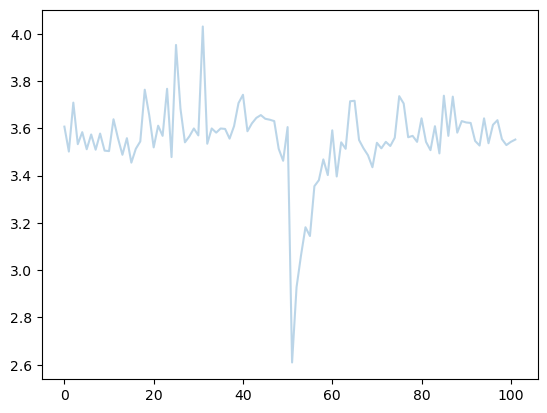

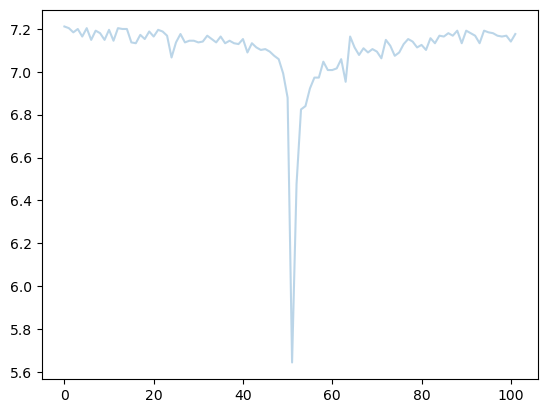

94it [00:07, 12.27it/s]

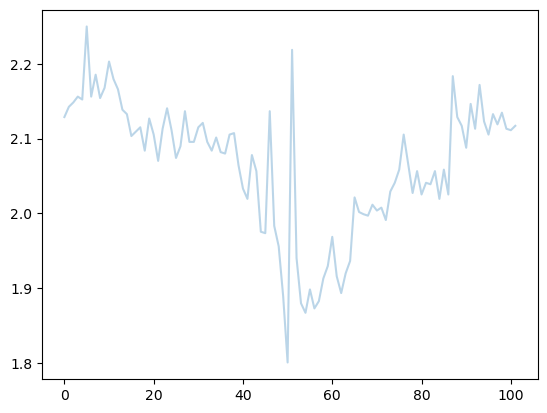

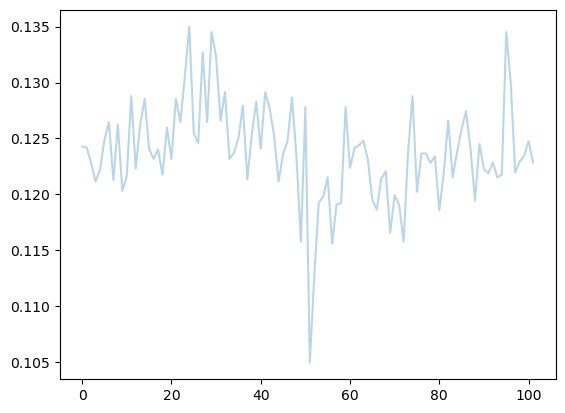

96it [00:08, 12.37it/s]

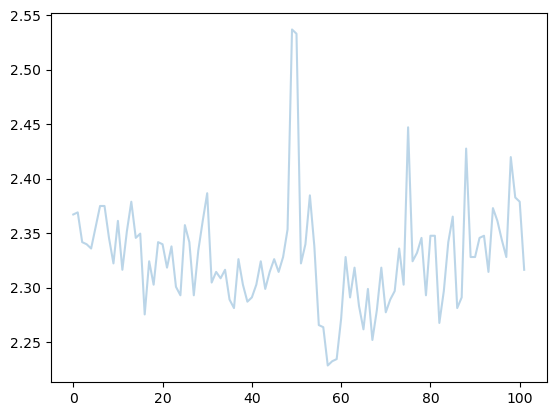

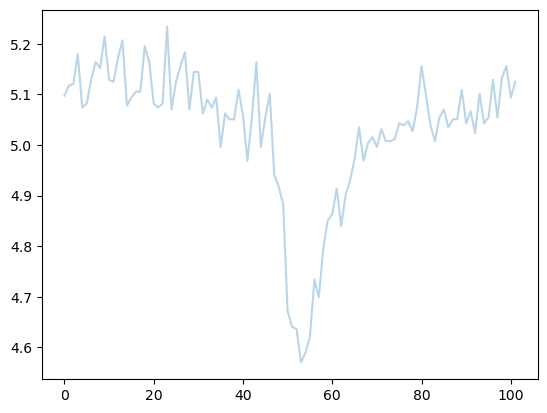

98it [00:08, 12.34it/s]

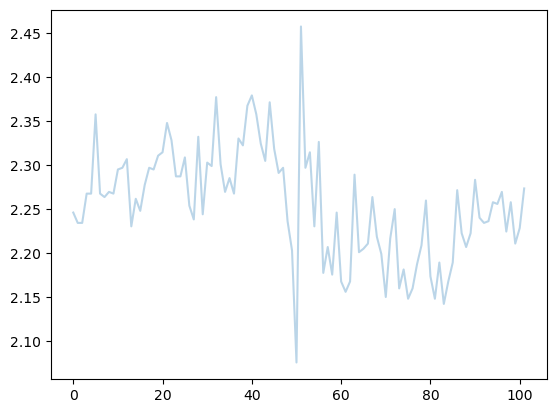

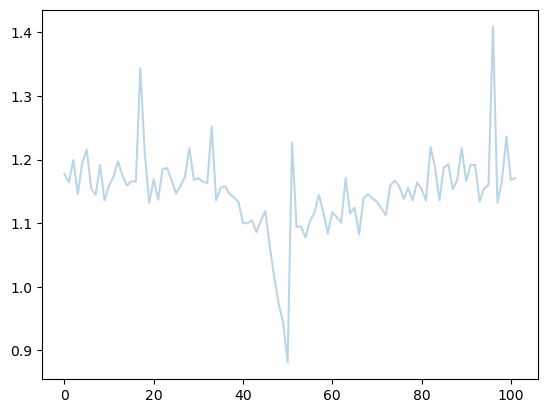

100it [00:08, 12.34it/s]

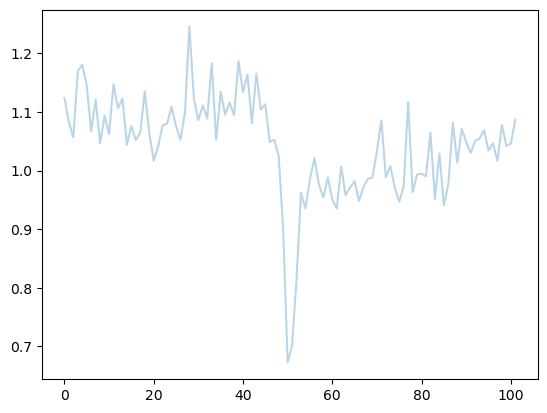

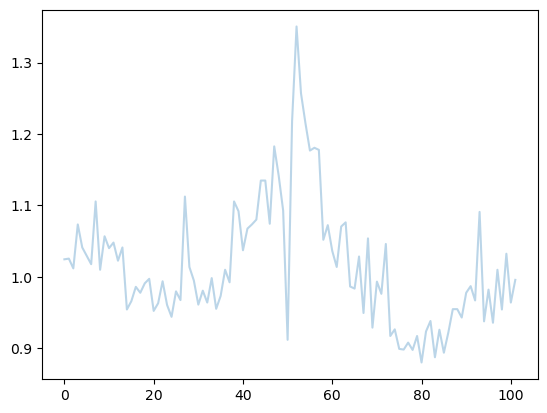

102it [00:08, 12.50it/s]

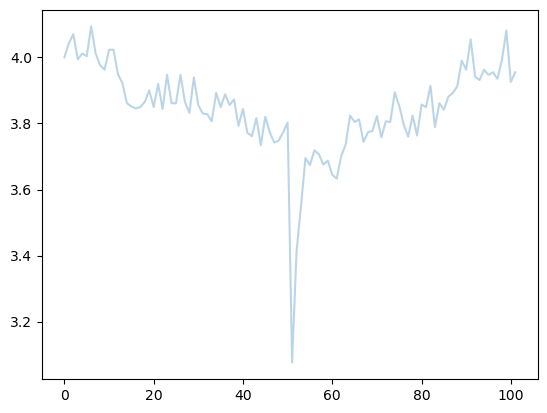

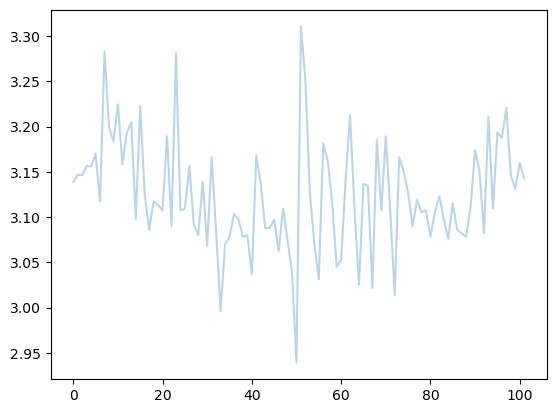

104it [00:08, 12.49it/s]

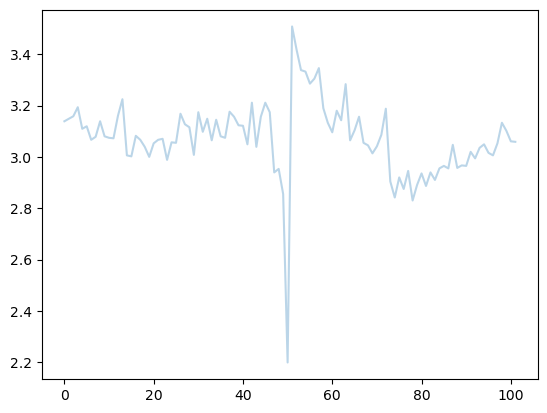

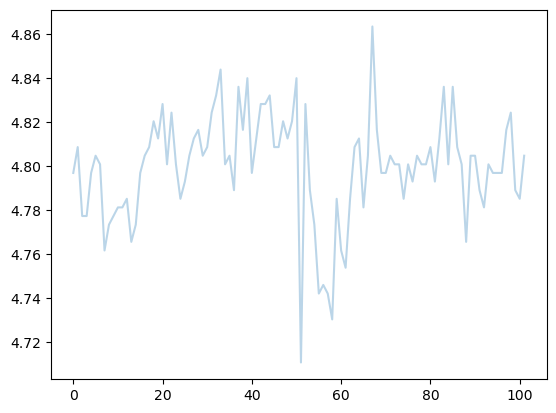

106it [00:08, 12.40it/s]

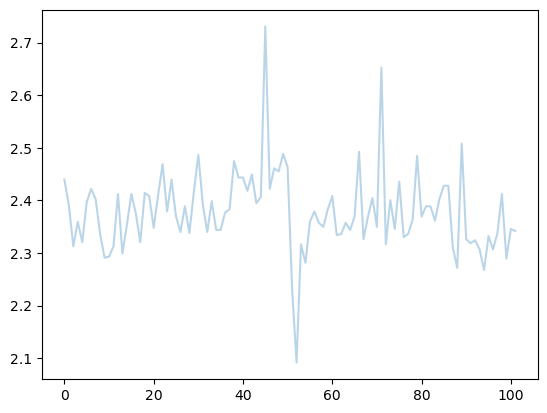

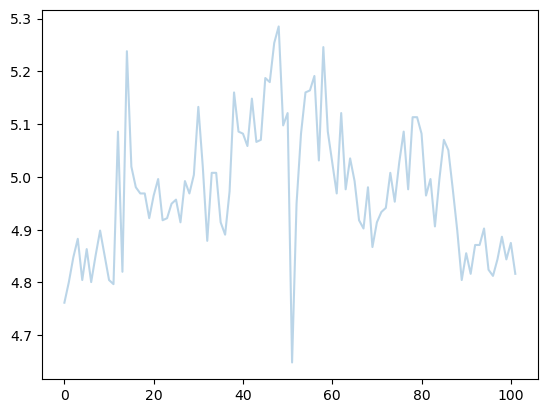

108it [00:08, 12.38it/s]

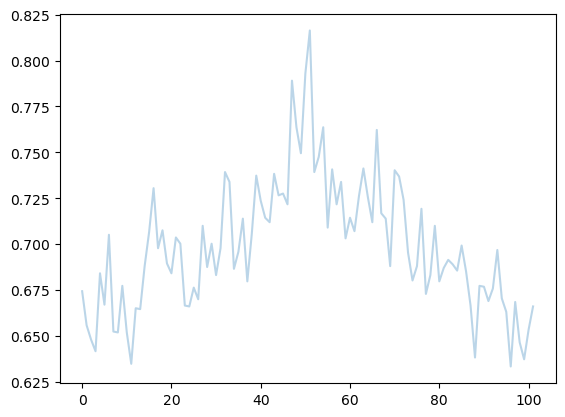

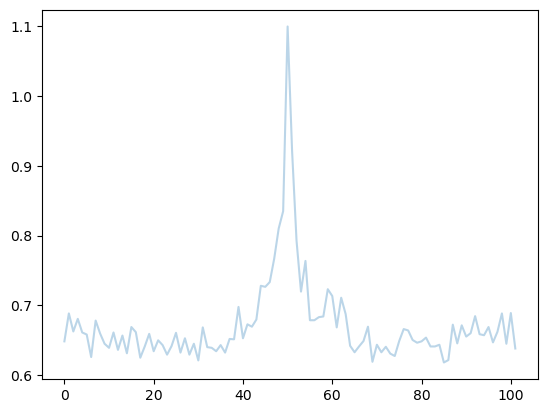

110it [00:09, 12.34it/s]

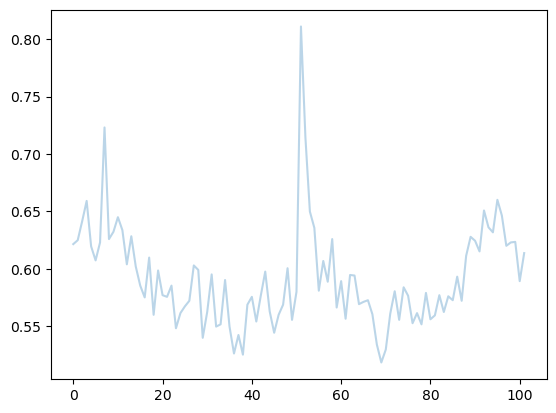

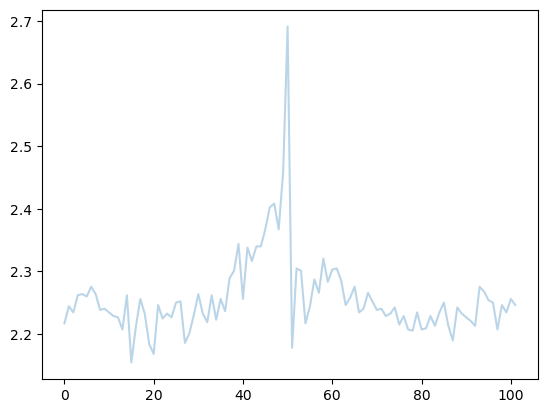

112it [00:09, 12.46it/s]

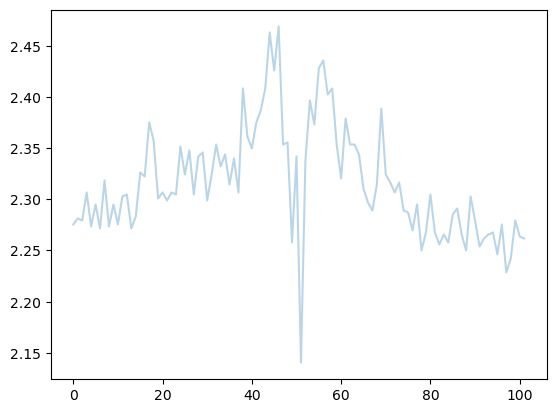

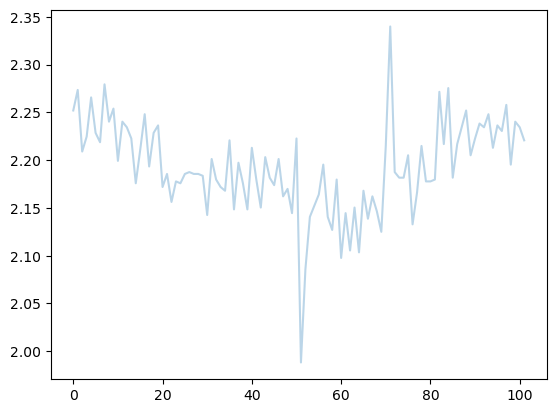

114it [00:09, 12.36it/s]

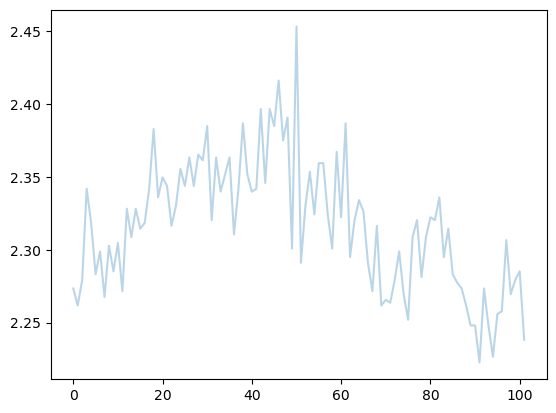

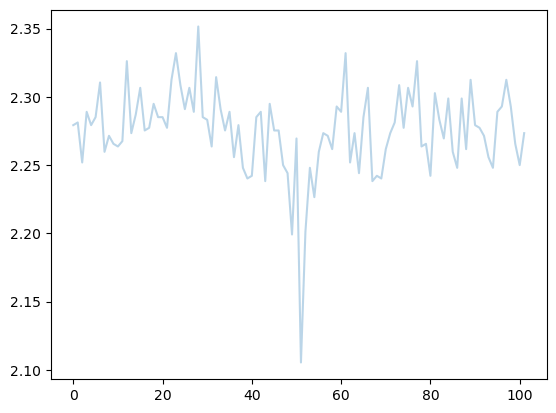

116it [00:09, 12.42it/s]

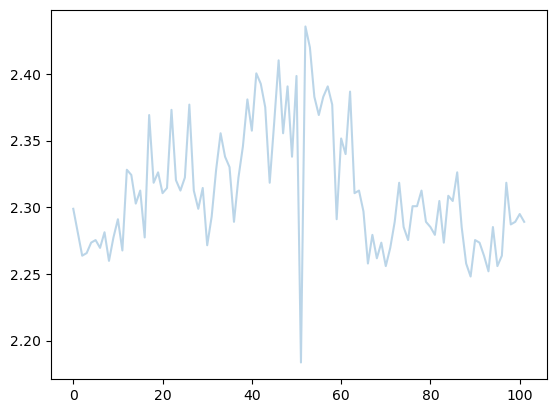

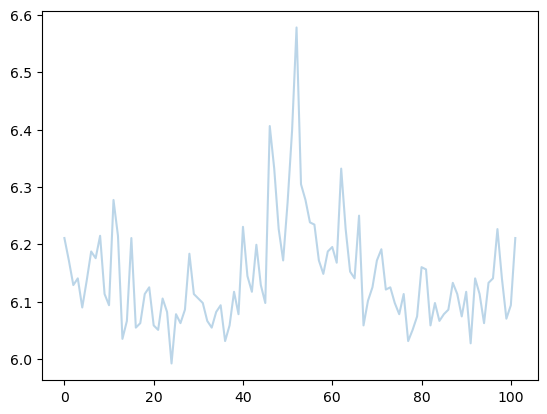

118it [00:09, 12.46it/s]

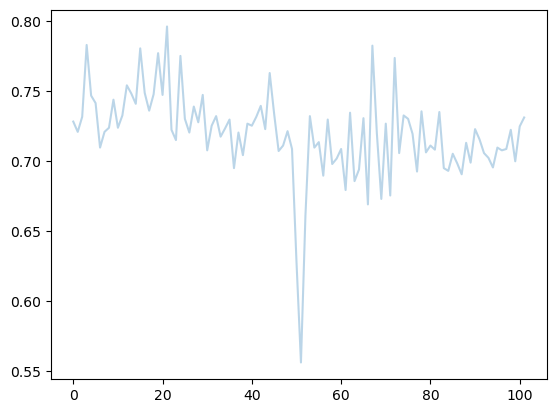

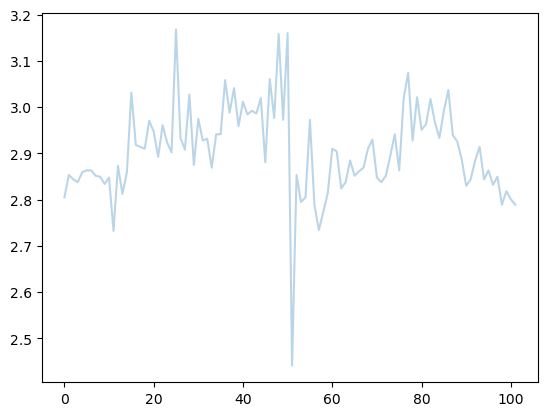

120it [00:09, 12.40it/s]

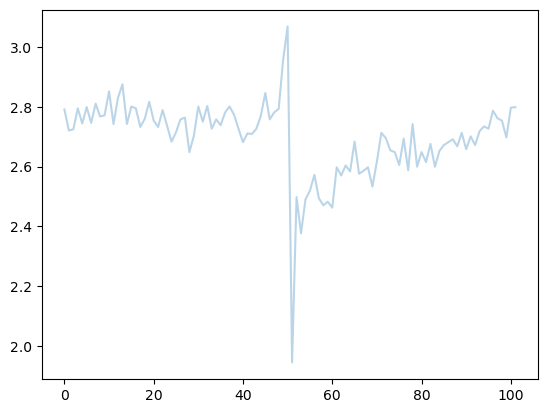

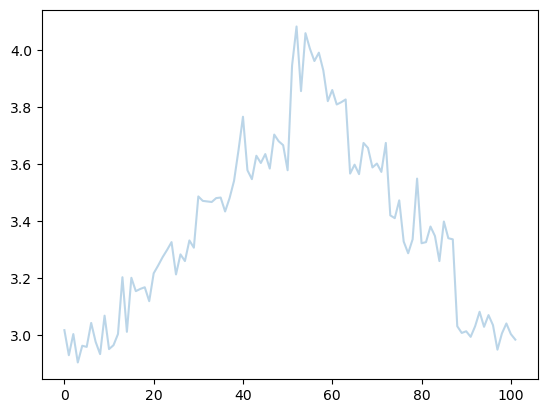

122it [00:10, 12.53it/s]

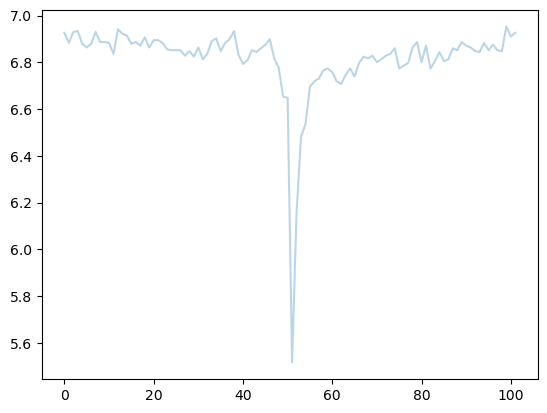

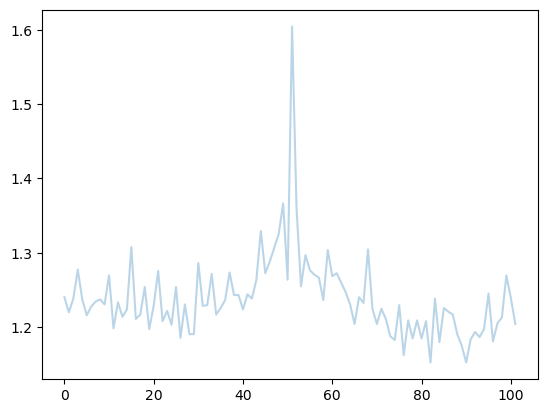

124it [00:10, 12.53it/s]

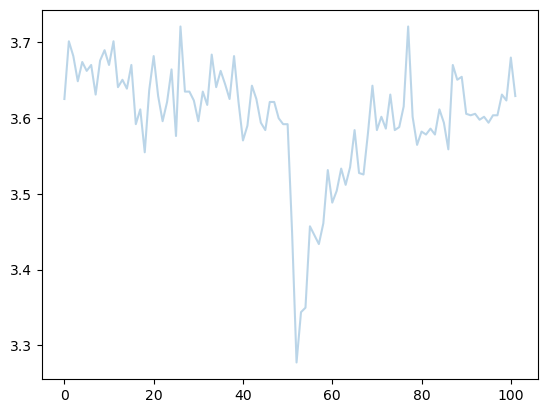

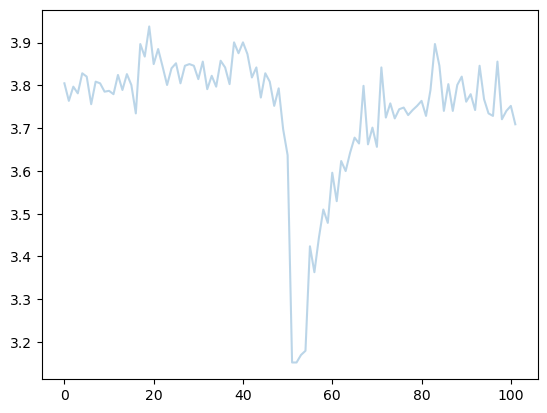

126it [00:10, 12.52it/s]

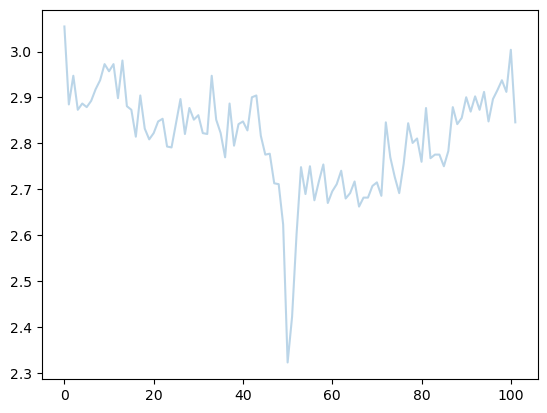

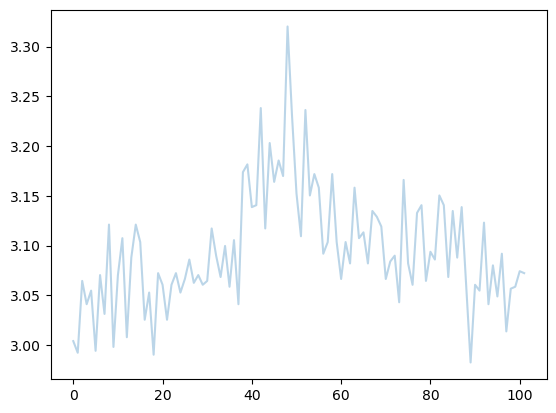

128it [00:10, 12.37it/s]

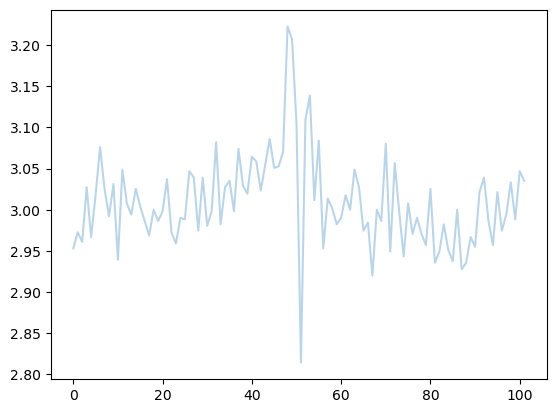

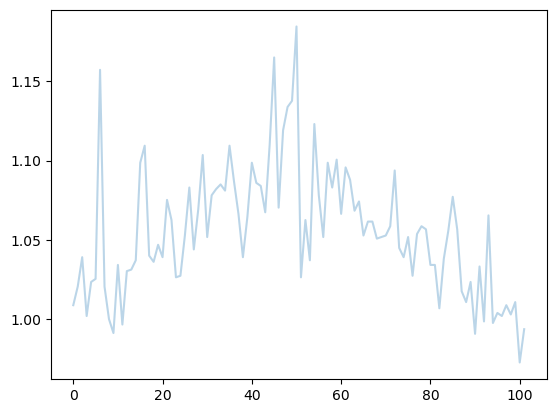

130it [00:10, 12.37it/s]

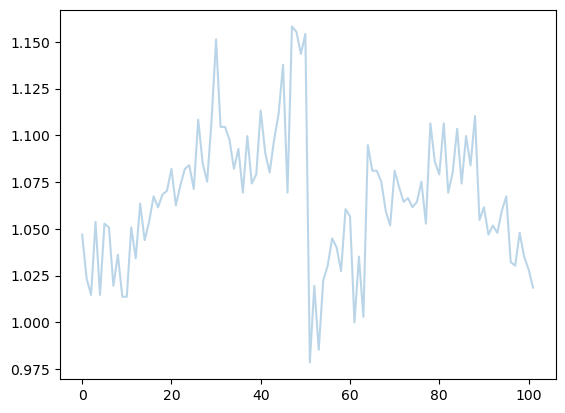

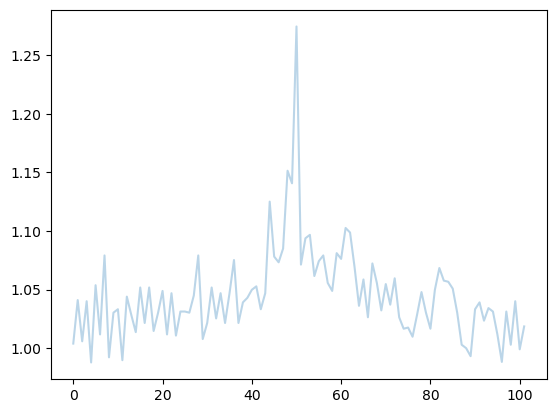

132it [00:10, 12.33it/s]

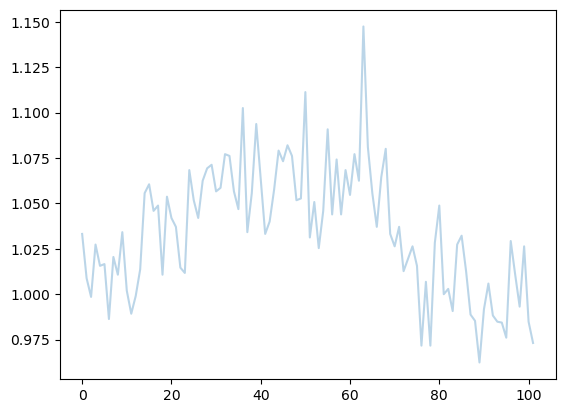

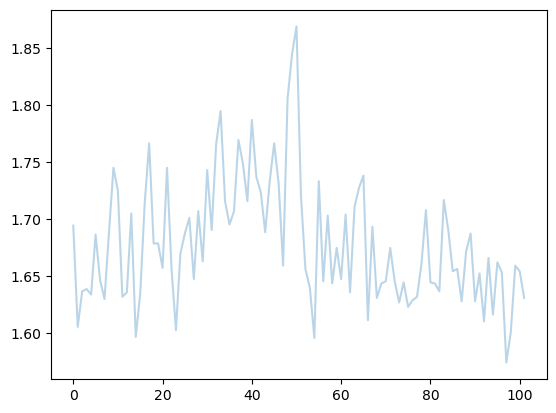

134it [00:11, 12.26it/s]

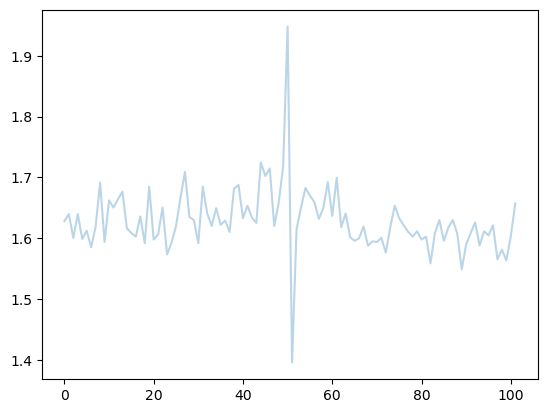

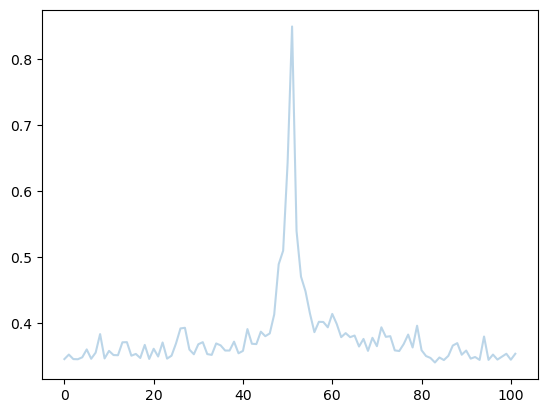

136it [00:11, 12.46it/s]

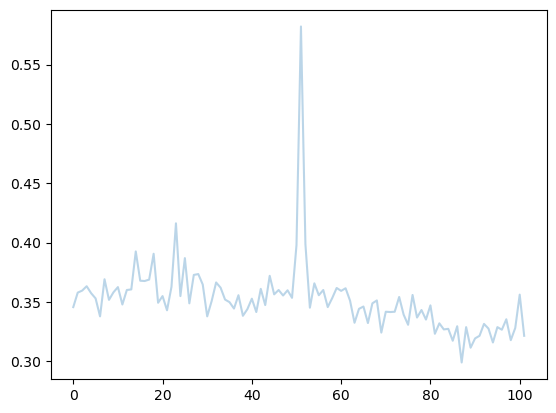

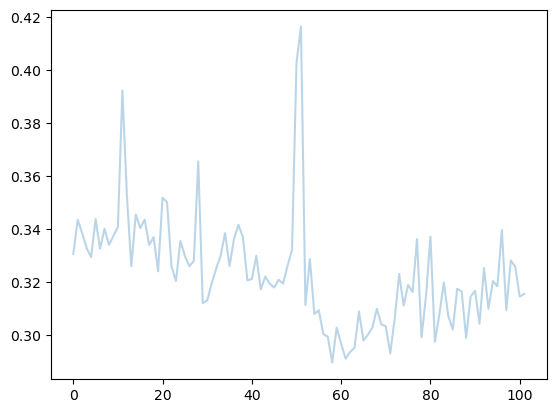

138it [00:11, 12.45it/s]

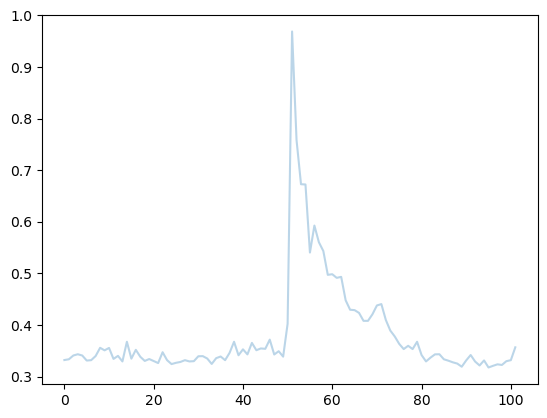

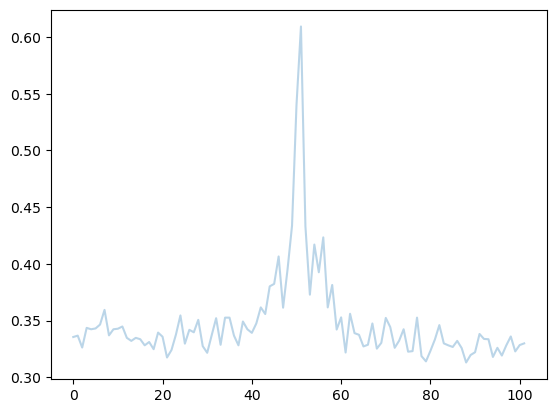

140it [00:11, 12.39it/s]

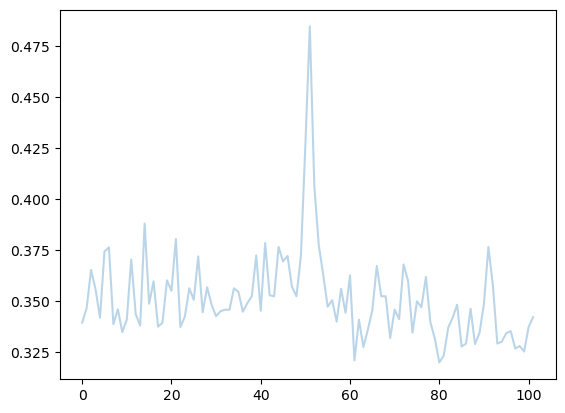

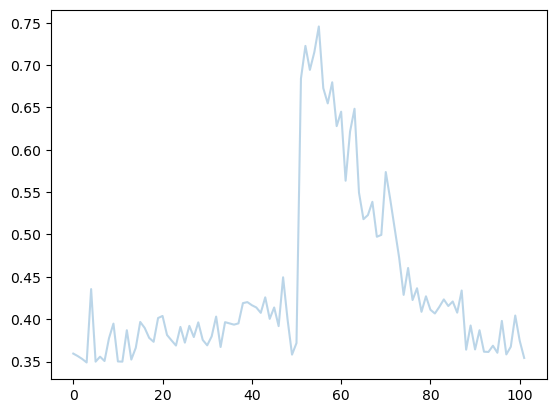

142it [00:11, 12.25it/s]

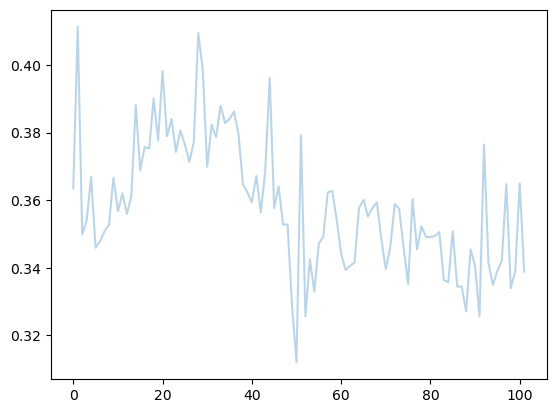

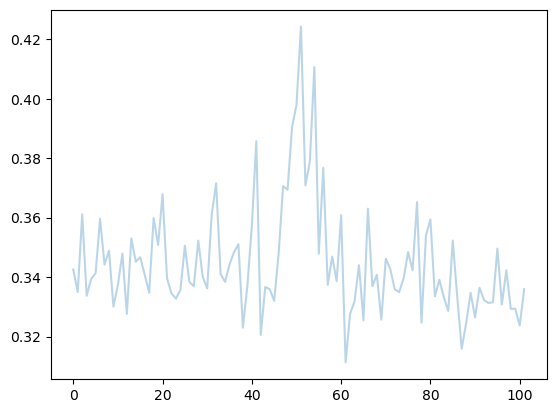

144it [00:11, 12.37it/s]

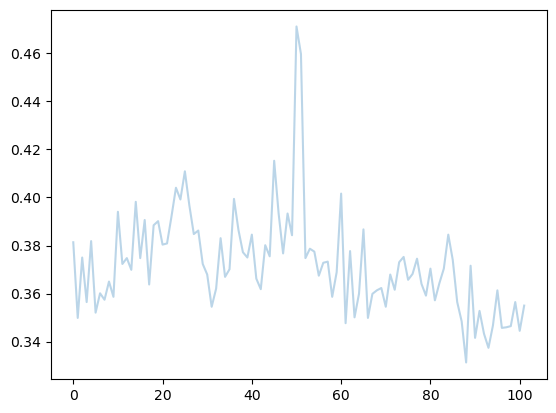

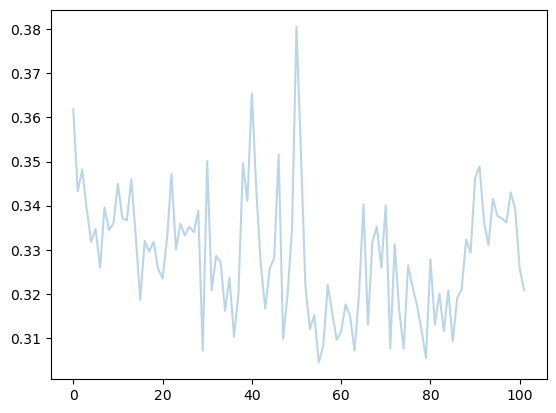

146it [00:12, 12.25it/s]

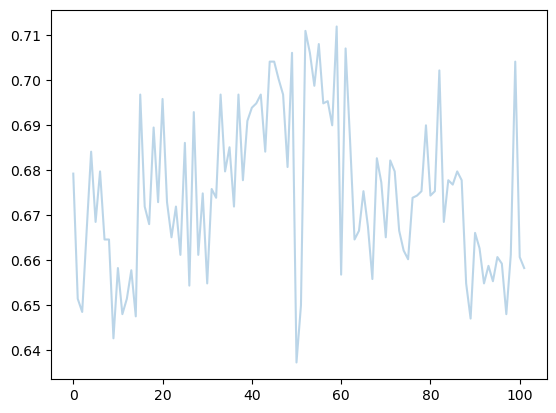

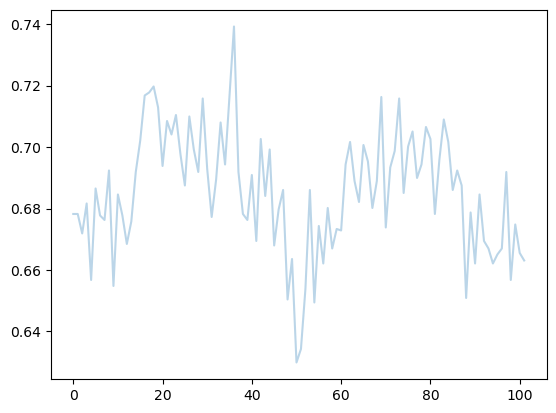

148it [00:12, 12.20it/s]

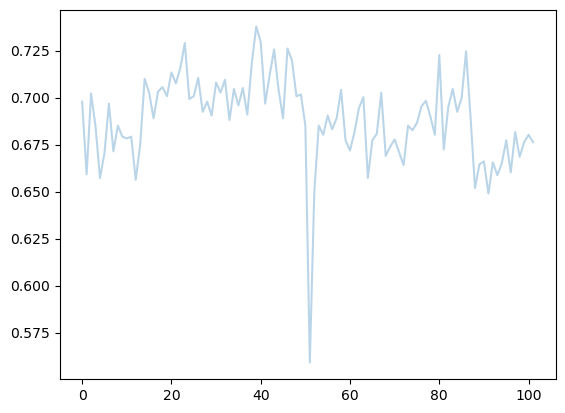

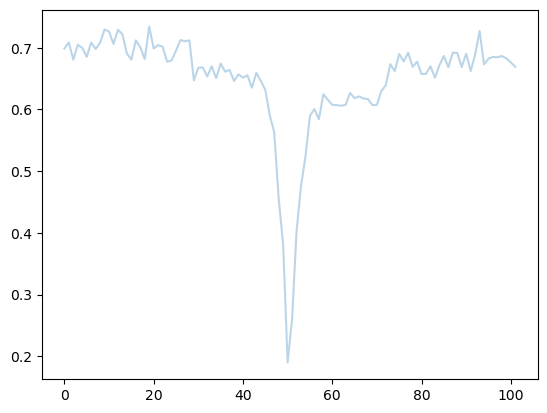

150it [00:12, 12.32it/s]

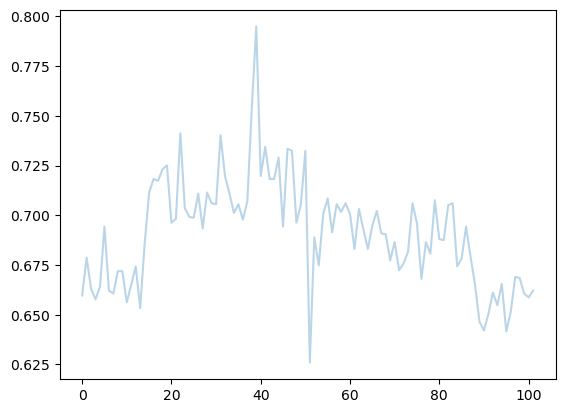

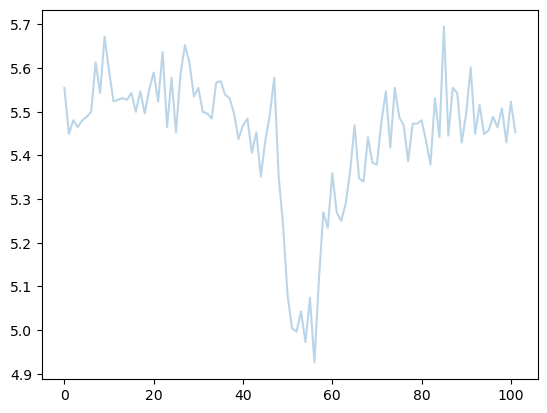

152it [00:12, 12.16it/s]

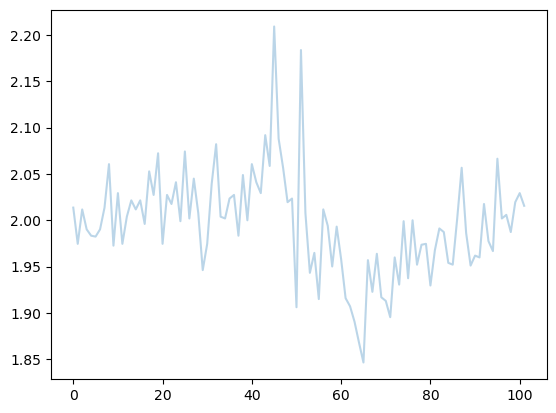

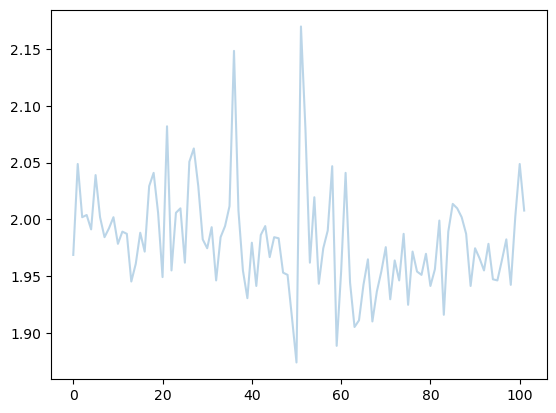

154it [00:12, 12.15it/s]

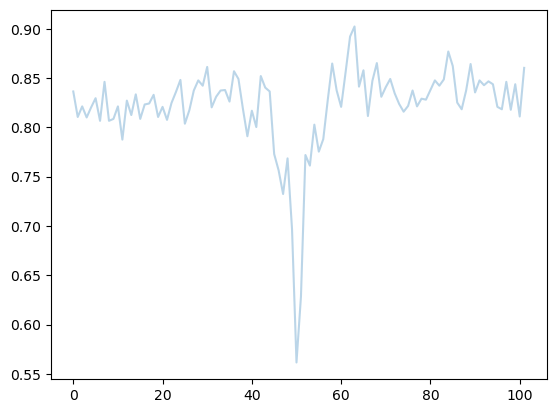

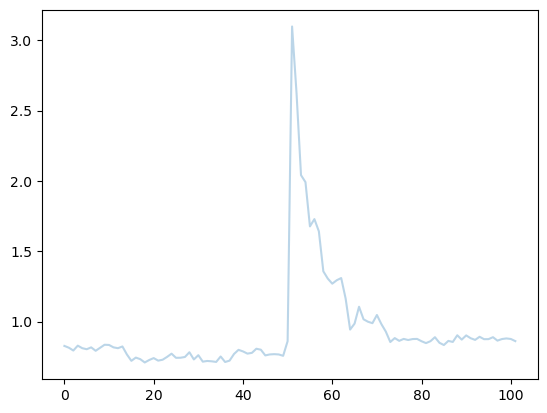

156it [00:12, 12.29it/s]

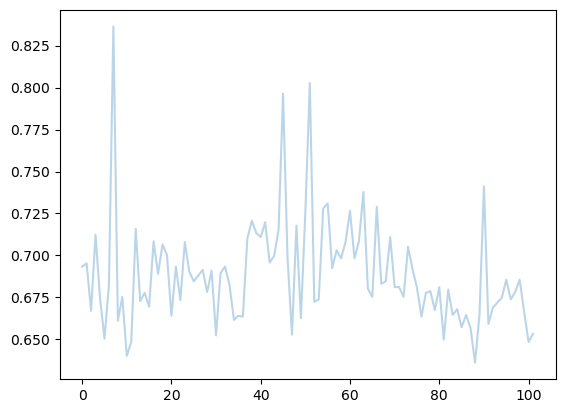

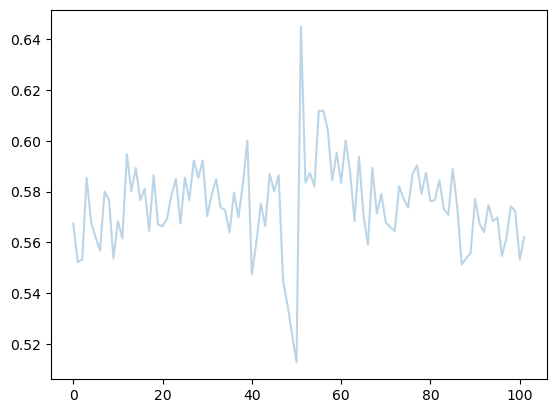

158it [00:13, 12.19it/s]

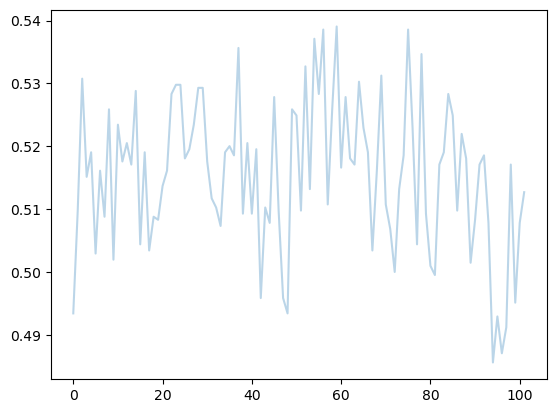

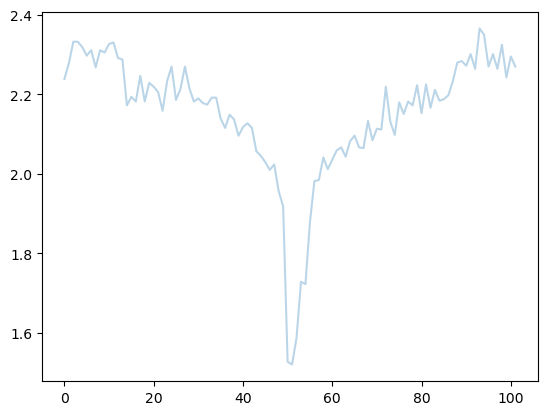

160it [00:13, 12.33it/s]

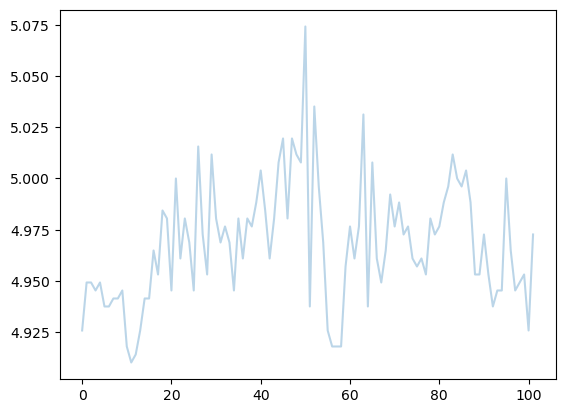

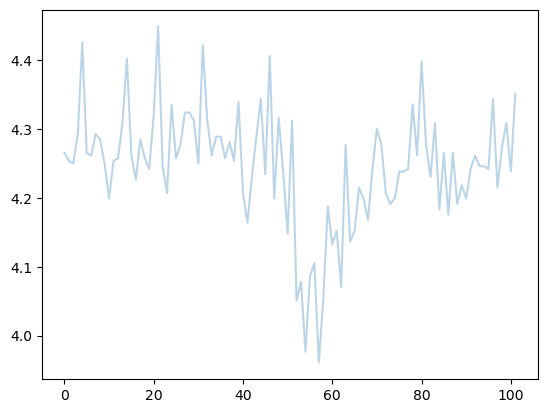

162it [00:13, 12.37it/s]

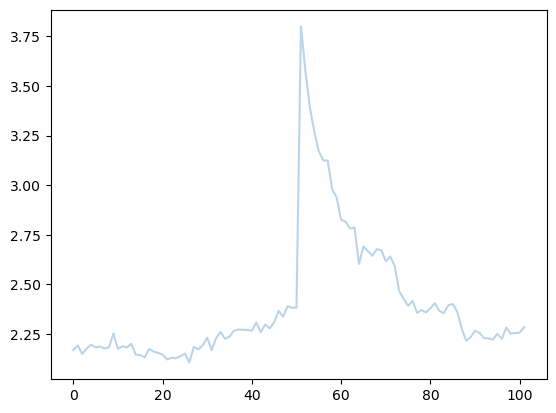

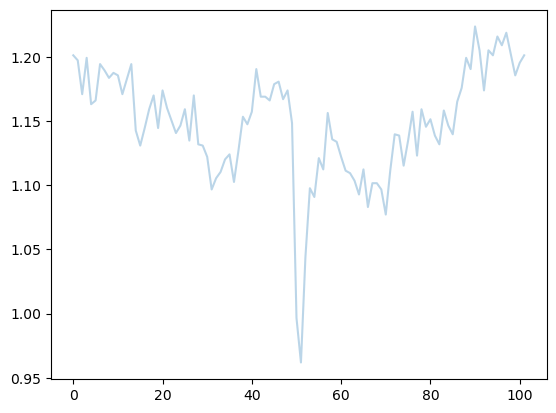

164it [00:13, 12.42it/s]

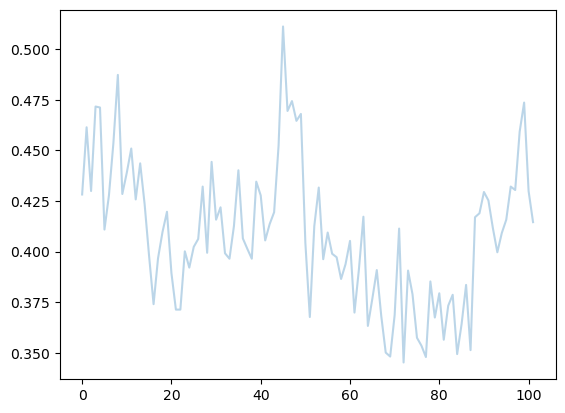

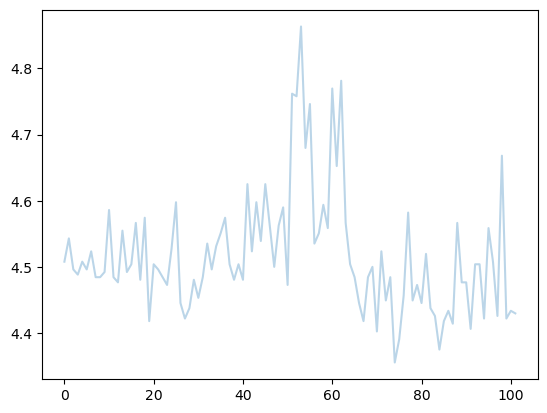

166it [00:13, 12.43it/s]

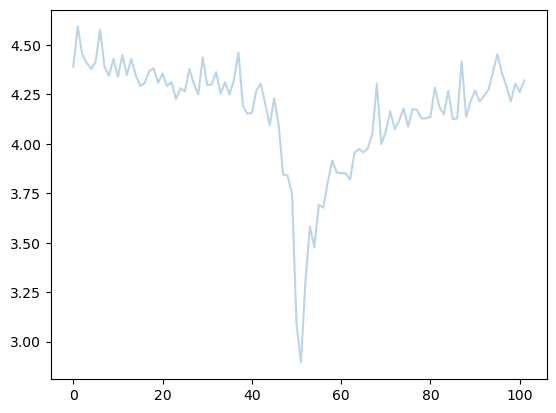

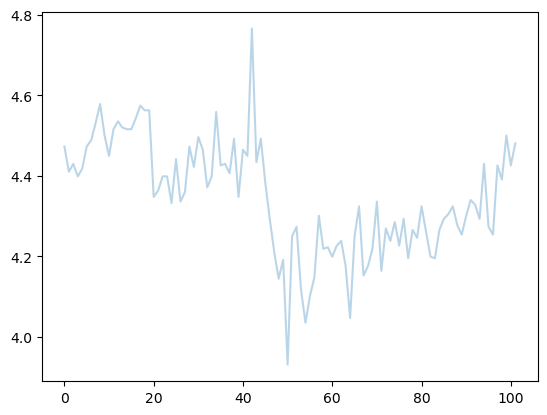

168it [00:14,  7.90it/s]

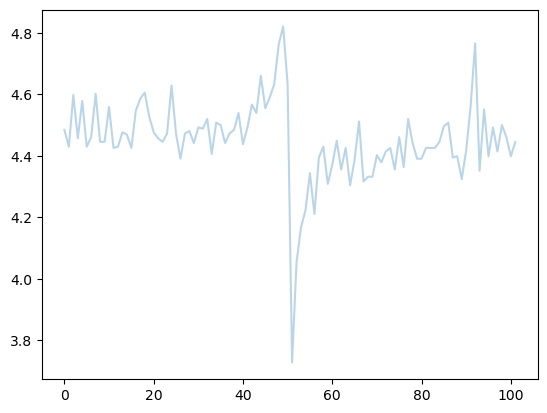

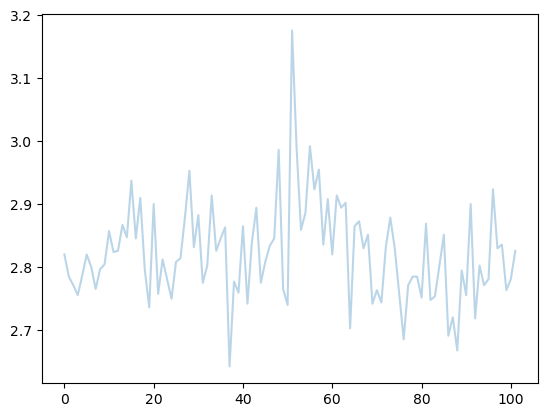

170it [00:14,  8.91it/s]

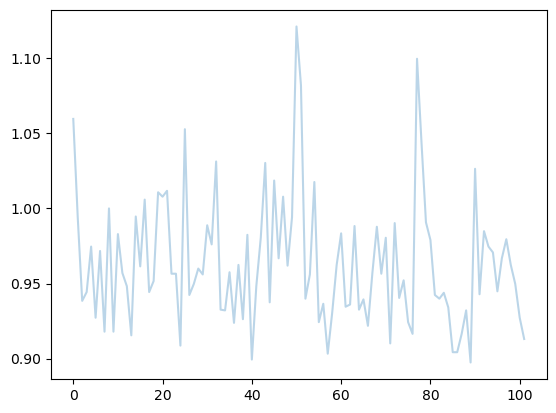

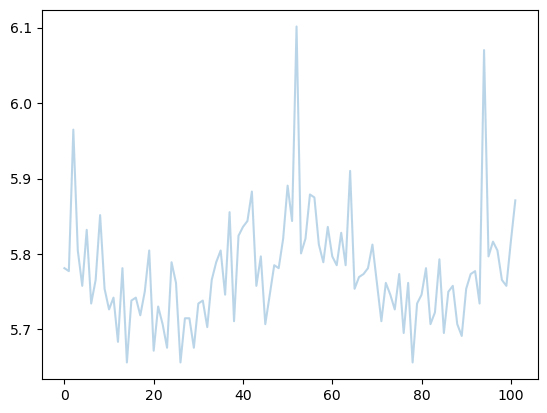

172it [00:14,  9.81it/s]

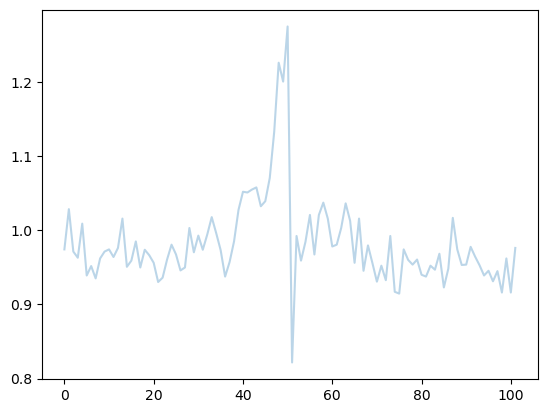

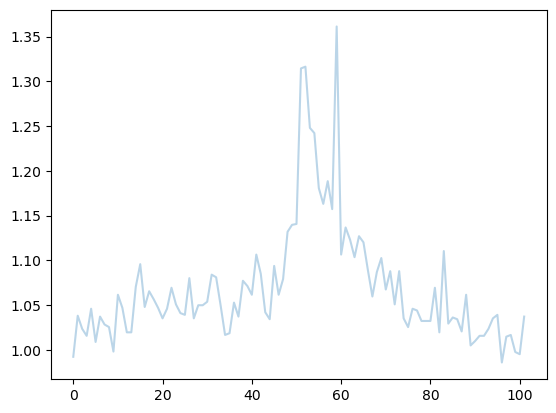

174it [00:14, 10.48it/s]

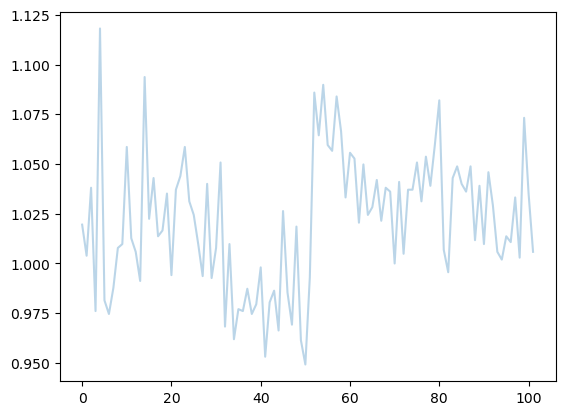

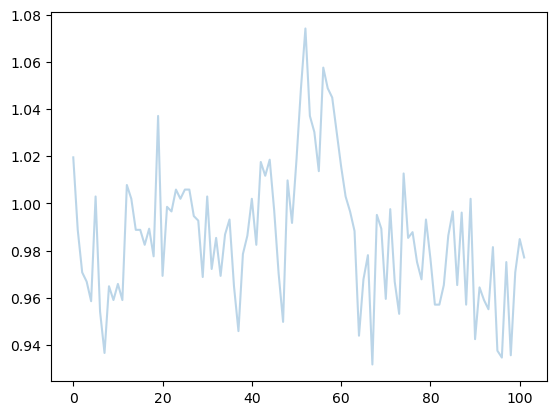

176it [00:14, 10.82it/s]

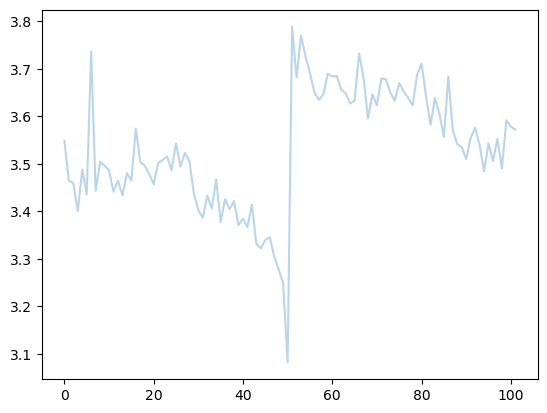

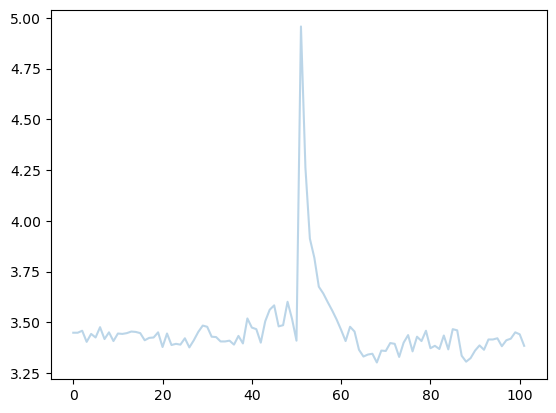

178it [00:14, 11.16it/s]

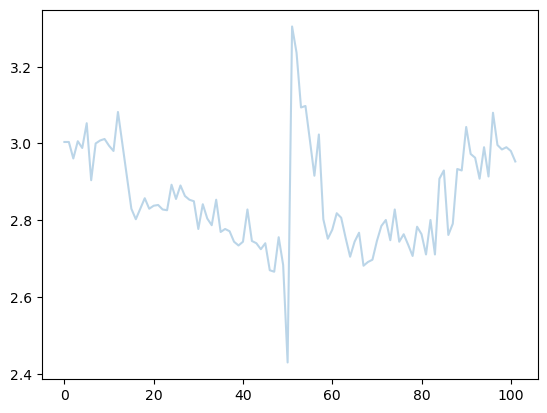

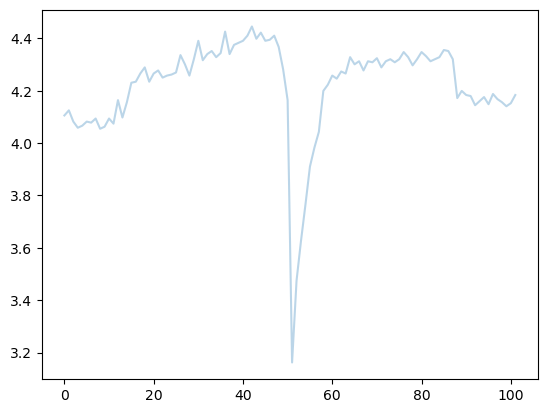

180it [00:15, 11.61it/s]

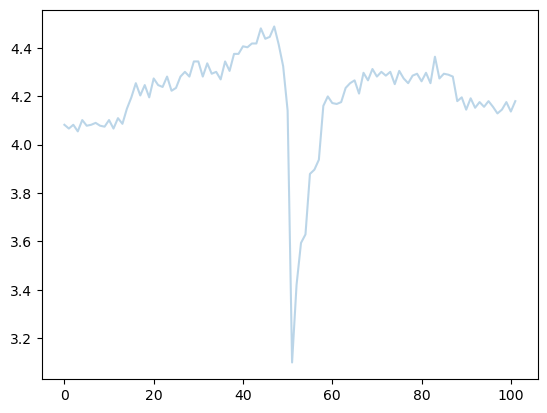

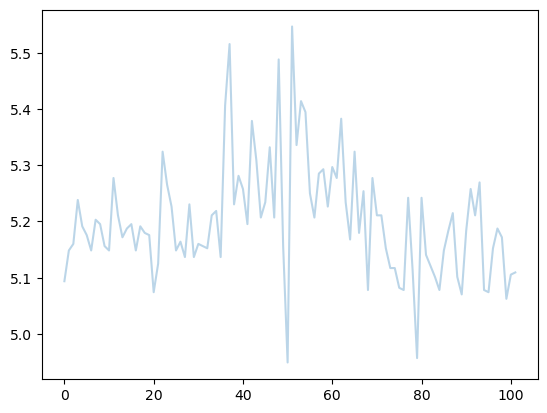

182it [00:15, 11.87it/s]

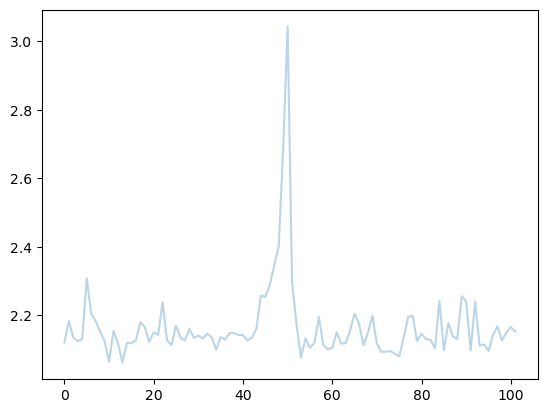

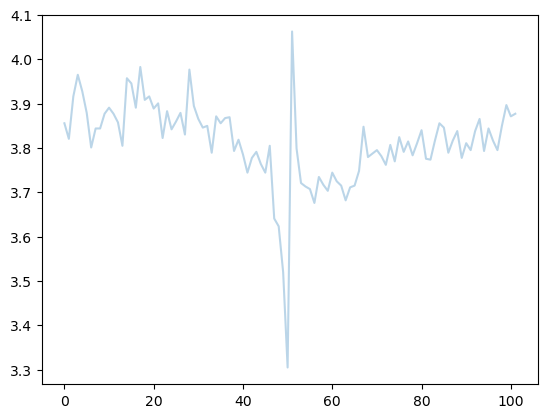

184it [00:15, 12.04it/s]

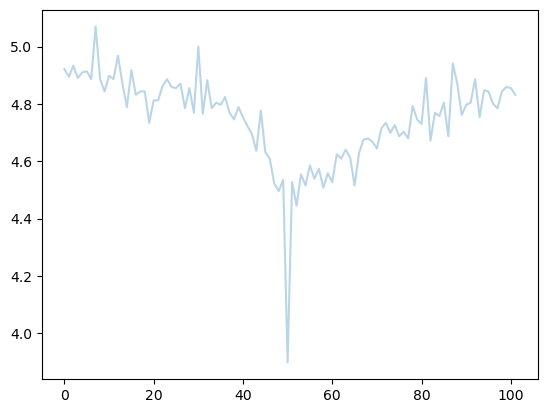

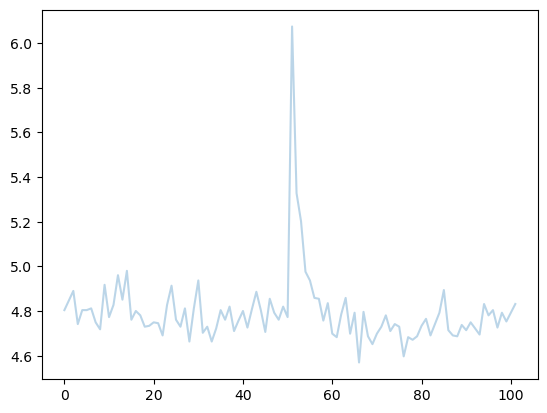

186it [00:15, 12.16it/s]

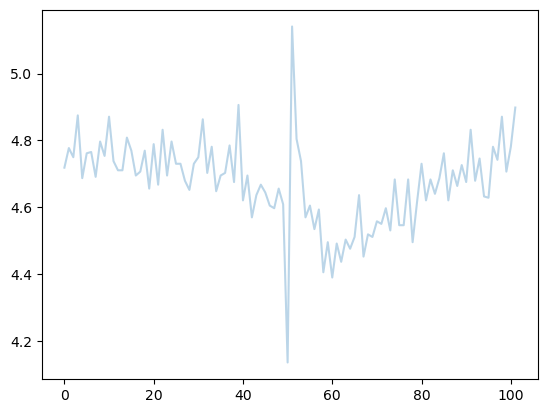

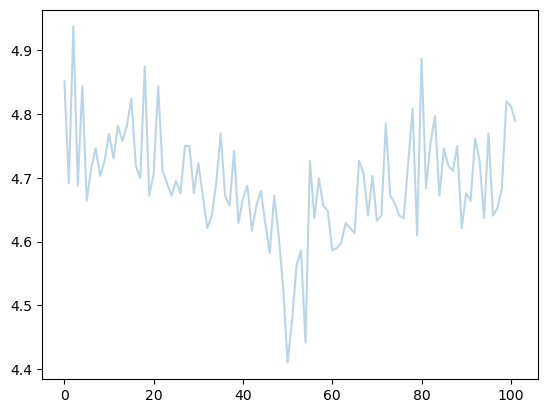

188it [00:15, 12.34it/s]

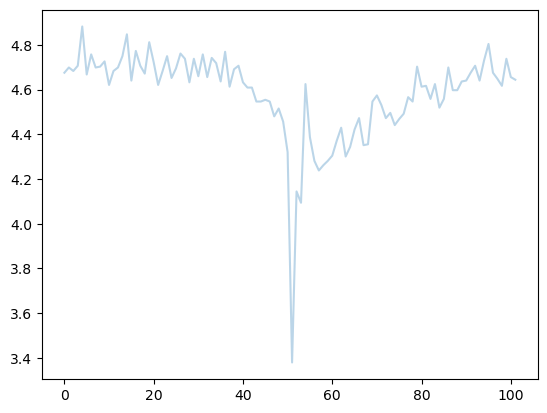

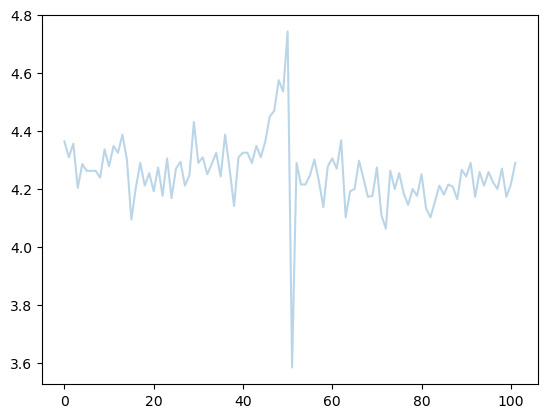

190it [00:15, 12.32it/s]

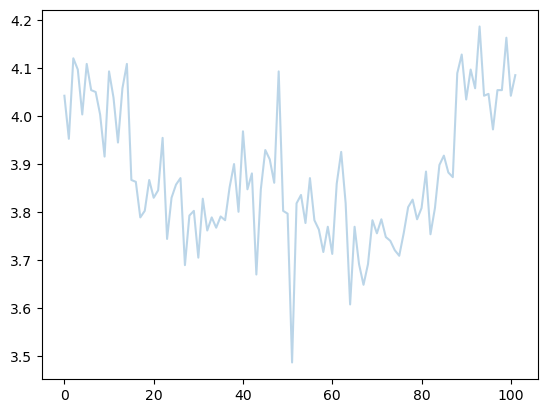

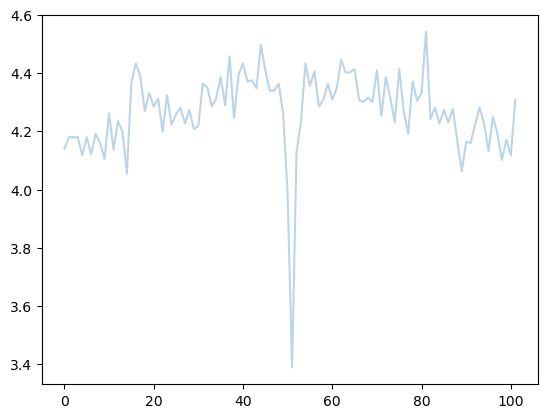

192it [00:16, 12.27it/s]

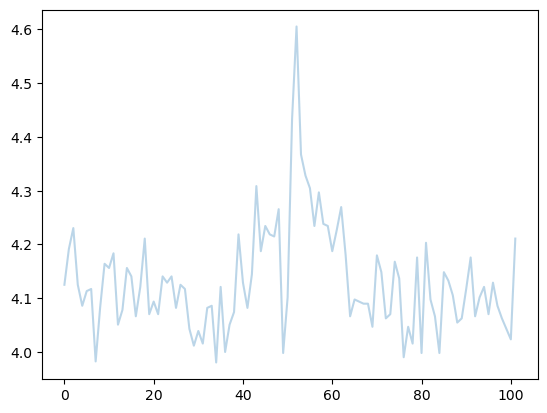

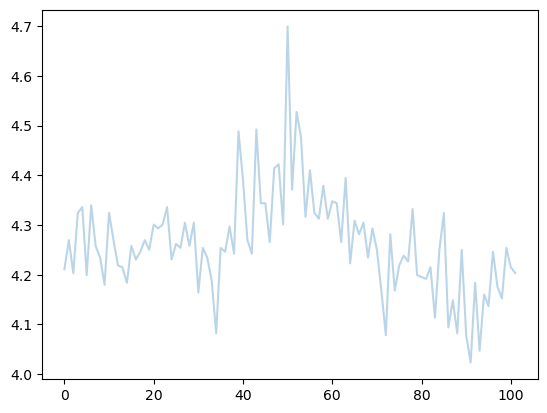

194it [00:16, 12.22it/s]

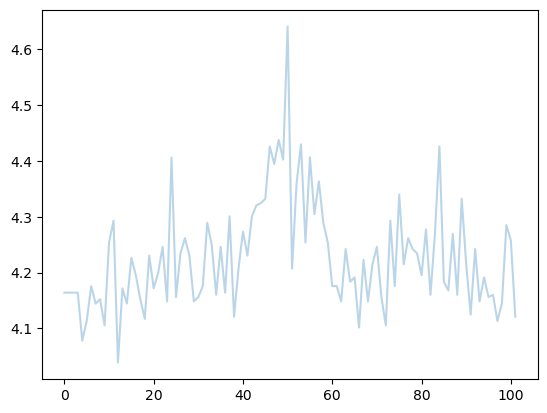

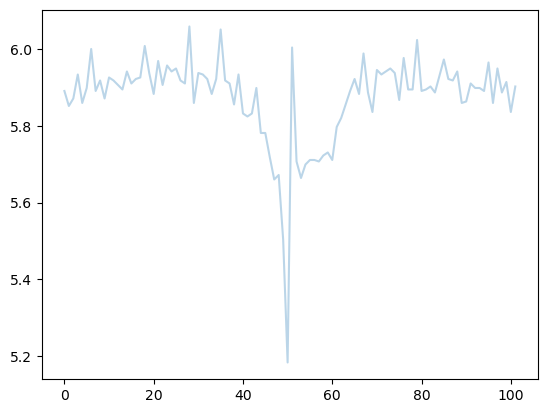

196it [00:16, 12.40it/s]

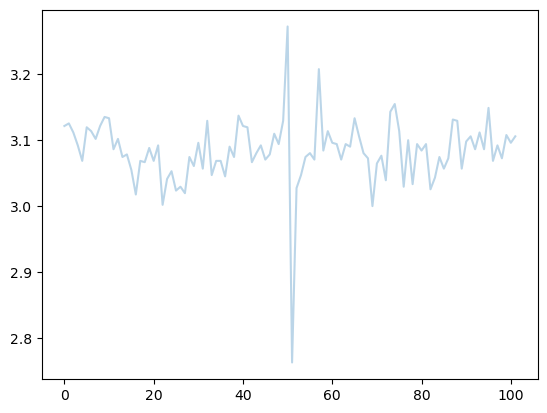

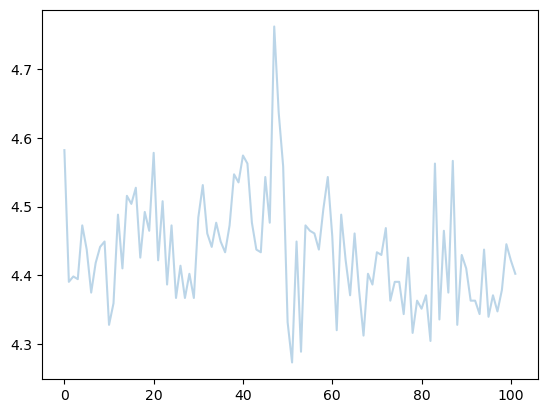

198it [00:16, 12.58it/s]

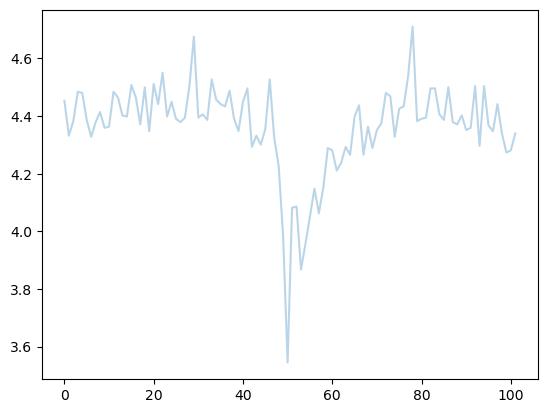

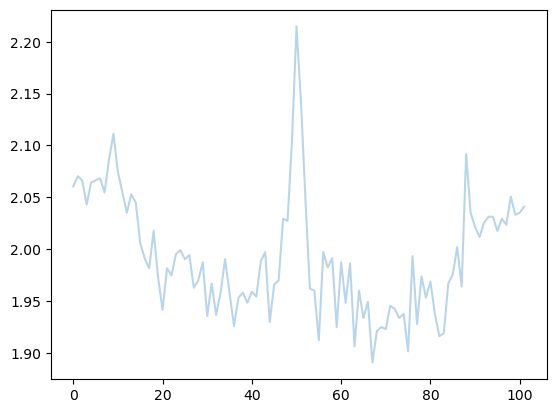

200it [00:16, 12.56it/s]

In [ ]:
result_normalized_effects = []
all_norm_effects = []
raw_preds = {}
for i, cell_line in enumerate(cell_line_info.keys()):
    track_output_index = cell_line_info[cell_line]['output']
    raw_preds[cell_line] = []
    cre_df_cell = cre_df[cre_df['cell_line'] == cell_line]
    cre_df_cell.insert(1, "distance to TSS (Kb)", [np.abs(int(i) - tss_tile[0]) // 1000 for i in cre_df_cell['tile_start'].values ])
    tests = []
    for j, (_, row) in tqdm(enumerate(cre_df_cell.iterrows())):
        tile_start, tile_end = [row['tile_start'], row['tile_end']]
        enf_data_id = f'{row["seq_id"]}_{tile_start}_{tile_end}'

        tile_start += delta_seq_length
        tile_end += delta_seq_length
        result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
        res = utils.read_pickle(result_path)

        
        control = res['mean_control'][:, cell_line_info[cell_line]['output']].mean()
        test = res['mean_mut'][:,:, cell_line_info[cell_line]['output']].mean(axis=-1).mean(axis=-1)
        # norm_effects = test / control
        norm_effects = test / np.max(test)
        all_norm_effects.append(norm_effects)
        df = pd.DataFrame([norm_effects, cre_tiles_starts_abs]).T
        df.columns = ['Fold change over control', 'Binned distance (Kb)']
        df['control'] = control
        wt = utils.read_pickle(f'../results/gencode_tss_predictions/borzoi/{row["seq_id"]}.pickle')['cage'][0, :, track_output_index].mean()
        df['Context effect'] = (wt - control) / wt
        df['wt'] = wt
        cre_definition_original = (test[np.argwhere(tile_start == cre_tiles_starts)[0][0]] - control) / control # using original position
        
        cre_max = (np.max(test) - control) / control
        cre_min = (np.min(test) - control) / control 

        df['cre_definition_original'] = cre_definition_original
        df['cre_min'] = cre_min
        df['cre_max'] = cre_max


        
        df['Normalized CRE effect (control)'] = row['Normalized CRE effect']
        raw_preds[cell_line].append(test)
        df['cell line'] = cell_line
        df['enformer context'] = row['context']
        df['enf_data_id'] = enf_data_id
        df['enformer tile class'] = row['tile class']
        df['seq_id'] = row['seq_id']
        result_normalized_effects.append(df)
        plt.plot(test, alpha=0.3)
        plt.show()
    break
        
result_normalized_effects = pd.concat(result_normalized_effects)

<Axes: xlabel='cre_definition_original', ylabel='Count'>

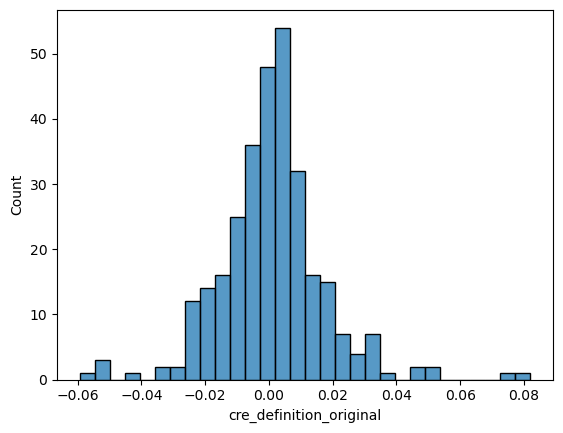

In [125]:
sns.histplot(x=result_normalized_effects.groupby('seq_id').mean('cre_definition_original')['cre_definition_original'])

<Axes: xlabel='cre_min', ylabel='Count'>

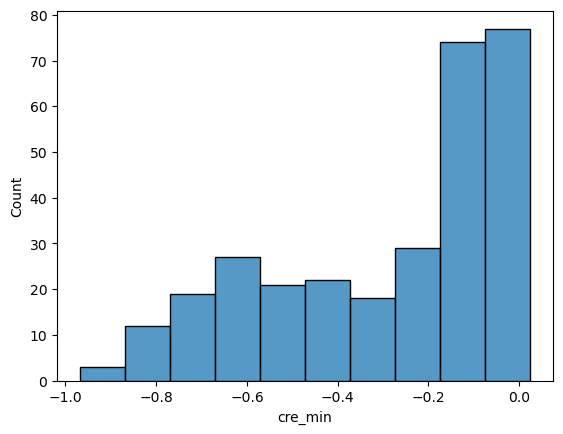

In [128]:
sns.histplot(x=result_normalized_effects.groupby('seq_id').mean('cre_definition_original')['cre_min'])

<Axes: xlabel='cre_max', ylabel='Count'>

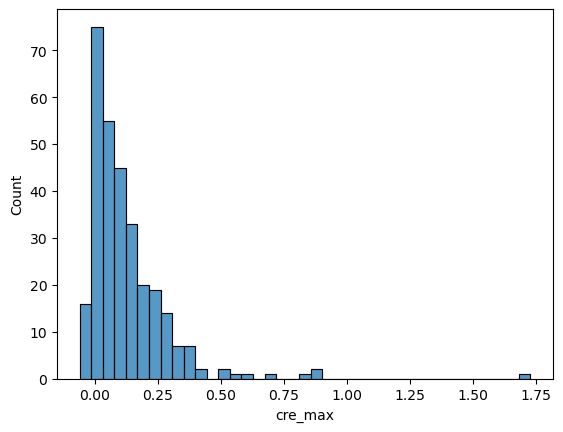

In [129]:
sns.histplot(x=result_normalized_effects.groupby('seq_id').mean('cre_definition_original')['cre_max'])

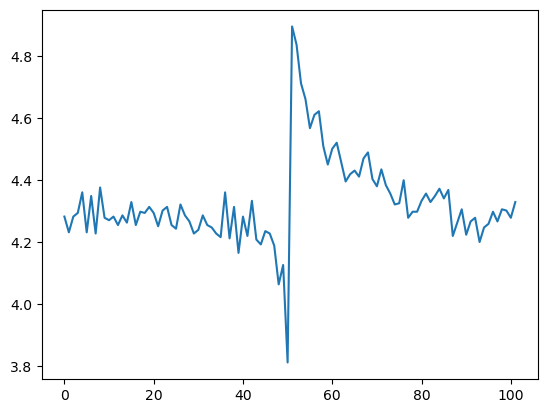

In [131]:
plt.plot(test)

In [121]:
result_normalized_effects

Fold change over control  Binned distance (Kb)   control  Context effect   
0                    0.418701                 255.0  2.753906        0.644043  \
1                    0.418457                 250.0  2.753906        0.644043   
2                    0.426270                 245.0  2.753906        0.644043   
3                    0.403809                 240.0  2.753906        0.644043   
4                    0.414062                 235.0  2.753906        0.644043   
..                        ...                   ...       ...             ...   
97                   0.871582                 235.0  4.914062        0.210815   
98                   0.879395                 240.0  4.914062        0.210815   
99                   0.878906                 245.0  4.914062        0.210815   
100                  0.874023                 250.0  4.914062        0.210815   
101                  0.884277                 255.0  4.914062        0.210815   

           wt  cre_definition  Normalized CRE effect (control) cell line   
0    7.734375       -0.022690                         0.333129      K562  \
1    7.734375       -0.022690                         0.333129      K562   
2    7.734375       -0.022690                         0.333129      K562   
3    7.734375       -0.022690                         0.333129      K562   
4    7.734375       -0.022690                         0.333129      K562   
..        ...             ...                              ...       ...   
97   6.226562       -0.003975                        -0.467084      PC-3   
98   6.226562       -0.003975                        -0.467084      PC-3   
99   6.226562       -0.003975                        -0.467084      PC-3   
100  6.226562       -0.003975                        -0.467084      PC-3   
101  6.226562       -0.003975                        -0.467084      PC-3   

    enformer context                                     enf_data_id   
0          enhancing          CHST11_chr12_104456947_+_100804_105804  \
1          enhancing          CHST11_chr12_104456947_+_100804_105804   
2          enhancing          CHST11_chr12_104456947_+_100804_105804   
3          enhancing          CHST11_chr12_104456947_+_100804_105804   
4          enhancing          CHST11_chr12_104456947_+_100804_105804   
..               ...                                             ...   
97         silencing  ENSG00000286165_chr2_189661518_+_100804_105804   
98         silencing  ENSG00000286165_chr2_189661518_+_100804_105804   
99         silencing  ENSG00000286165_chr2_189661518_+_100804_105804   
100        silencing  ENSG00000286165_chr2_189661518_+_100804_105804   
101        silencing  ENSG00000286165_chr2_189661518_+_100804_105804   

    enformer tile class                            seq_id  
0              Enhancer          CHST11_chr12_104456947_+  
1              Enhancer          CHST11_chr12_104456947_+  
2              Enhancer          CHST11_chr12_104456947_+  
3              Enhancer          CHST11_chr12_104456947_+  
4              Enhancer          CHST11_chr12_104456947_+  
..                  ...                               ...  
97             Silencer  ENSG00000286165_chr2_189661518_+  
98             Silencer  ENSG00000286165_chr2_189661518_+  
99             Silencer  ENSG00000286165_chr2_189661518_+  
100            Silencer  ENSG00000286165_chr2_189661518_+  
101            Silencer  ENSG00000286165_chr2_189661518_+  

[53652 rows x 12 columns]

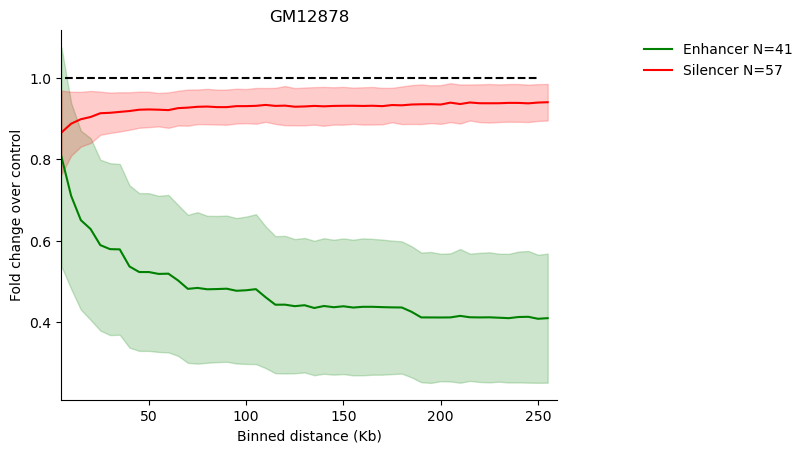

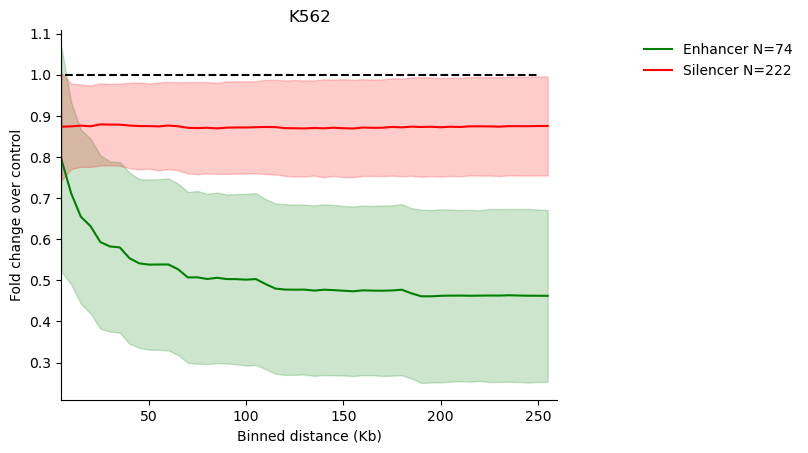

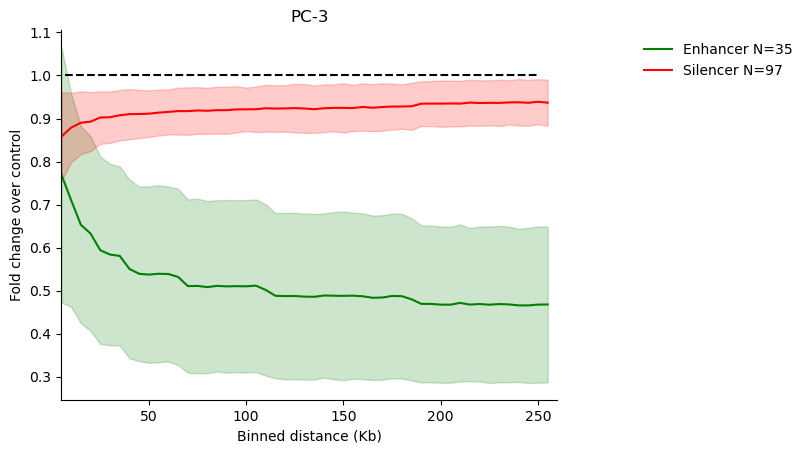

In [34]:
for cell_line, df in result_normalized_effects.groupby('cell line'):
#     df = pd.concat([df[(df['context']=='silencing') & (df['tile class']=='Enhancer')],
#                     df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
# ])
#     df = pd.concat([df[(df['context']=='enhancing') & (df['tile class']=='Enhancer')], df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
# ])
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//len(cre_tiles_starts_abs)}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//len(cre_tiles_starts_abs)}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    ax=sns.lineplot(data=df, x='Binned distance (Kb)', y='Fold change over control', hue='tile class', ci='sd',
              palette=my_palette)
    ax.plot([1,250],[1,1], '--k')
    ax.set_xlim([5, 260])
    # ax.set_ylim(0,1.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)

    plt.legend(frameon=False, bbox_to_anchor=[1.5,1])
    plt.show()

In [51]:
(result_normalized_effects['mutant'] - result_normalized_effects['control']) / result_normalized_effects['control']
(result_normalized_effects['mutant'] - result_normalized_effects['control']) / result_normalized_effects['wt']


KeyError: 'mutant'

In [52]:
df

Fold change over control  Binned distance (Kb)   control        wt   
0                    0.874512                 255.0  4.914062  6.226562  \
1                    0.864258                 250.0  4.914062  6.226562   
2                    0.874512                 245.0  4.914062  6.226562   
3                    0.876953                 240.0  4.914062  6.226562   
4                    0.890625                 235.0  4.914062  6.226562   
..                        ...                   ...       ...       ...   
97                   0.871582                 235.0  4.914062  6.226562   
98                   0.879395                 240.0  4.914062  6.226562   
99                   0.878906                 245.0  4.914062  6.226562   
100                  0.874023                 250.0  4.914062  6.226562   
101                  0.884277                 255.0  4.914062  6.226562   

     Normalized CRE effect (control) cell line    context   
0                          -0.467084      PC-3  silencing  \
1                          -0.467084      PC-3  silencing   
2                          -0.467084      PC-3  silencing   
3                          -0.467084      PC-3  silencing   
4                          -0.467084      PC-3  silencing   
..                               ...       ...        ...   
97                         -0.467084      PC-3  silencing   
98                         -0.467084      PC-3  silencing   
99                         -0.467084      PC-3  silencing   
100                        -0.467084      PC-3  silencing   
101                        -0.467084      PC-3  silencing   

                                        enf_data_id tile class  
0    ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
1    ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
2    ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
3    ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
4    ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
..                                              ...        ...  
97   ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
98   ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
99   ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
100  ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  
101  ENSG00000286165_chr2_189661518_+_100804_105804   Silencer  

[102 rows x 9 columns]

In [134]:
result_normalized_effects[['cell line', 'context', 'tile class', 'control', 'enf_data_id']].drop_duplicates('enf_data_id')

cell line    context tile class   control   
0       PC-3  enhancing   Enhancer  1.271484  \
0       PC-3  enhancing   Enhancer  3.062500   
0       PC-3  enhancing   Enhancer  1.611328   
0       PC-3  enhancing   Enhancer  0.040405   
0       PC-3  enhancing   Enhancer  2.458984   
..       ...        ...        ...       ...   
0       K562  silencing   Silencer  0.930176   
0       K562  silencing   Silencer  0.779785   
0       K562  silencing   Silencer  2.292969   
0       K562  silencing   Silencer  0.424316   
0       K562  silencing   Silencer  0.373291   

                                  enf_data_id  
0         SQOR_chr15_45635028_+_100804_105804  
0   GADD45GIP1_chr19_12957223_-_100804_105804  
0       MIF4GD_chr17_75271227_-_100804_105804  
0        ZNF619_chr3_40477141_+_100804_105804  
0      ALKBH2_chr12_109093472_-_100804_105804  
..                                        ...  
0       ZNF723_chr19_22832290_+_115804_120804  
0       ZNF723_chr19_22832290_+_120804_125804  
0        ZFP90_chr16_68539290_+_120804_125804  
0          ACSL6_chr5_131994579_-_70804_75804  
0        ACSL6_chr5_131994579_-_150804_155804  

[451 rows x 5 columns]

In [135]:
enformer_results = pd.read_csv('../results/summary_csvs/enformer/distance_test.csv')

In [138]:
merged_df = result_normalized_effects.merge(enformer_results, on='enf_data_id', suffixes=['_borzoi', '_enformer']).drop_duplicates('enf_data_id')

<Axes: xlabel='control_borzoi', ylabel='control_enformer'>

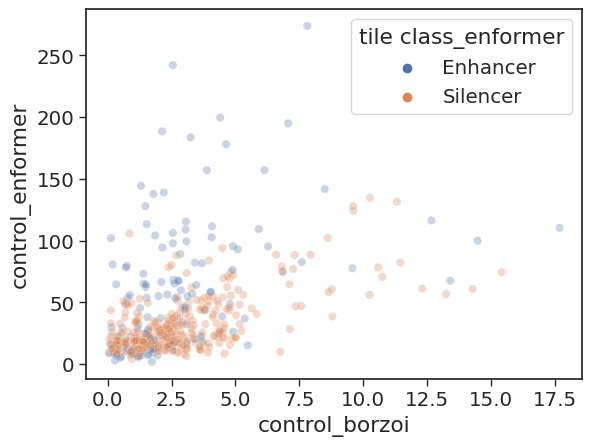

In [142]:
sns.scatterplot(data=merged_df, x='control_borzoi', y='control_enformer', hue='tile class_enformer', alpha=0.3)

In [131]:
enformer_results

Unnamed: 0  Fold change over control  Binned distance (Kb)   
0               0                  0.101222                  95.0  \
1               1                  0.105104                  90.0   
2               2                  0.088657                  85.0   
3               3                  0.099989                  80.0   
4               4                  0.117853                  75.0   
...           ...                       ...                   ...   
19983          33                  0.860996                  75.0   
19984          34                  0.839668                  80.0   
19985          35                  0.861466                  85.0   
19986          36                  0.833532                  90.0   
19987          37                  0.909147                  95.0   

       Normalized CRE effect (control) cell line    control   
0                             0.377385      PC-3  45.395157  \
1                             0.377385      PC-3  45.395157   
2                             0.377385      PC-3  45.395157   
3                             0.377385      PC-3  45.395157   
4                             0.377385      PC-3  45.395157   
...                                ...       ...        ...   
19983                        -0.350818      K562  22.181135   
19984                        -0.350818      K562  22.181135   
19985                        -0.350818      K562  22.181135   
19986                        -0.350818      K562  22.181135   
19987                        -0.350818      K562  22.181135   

                                enf_data_id    context tile class  
0       SQOR_chr15_45635028_+_100804_105804  enhancing   Enhancer  
1       SQOR_chr15_45635028_+_100804_105804  enhancing   Enhancer  
2       SQOR_chr15_45635028_+_100804_105804  enhancing   Enhancer  
3       SQOR_chr15_45635028_+_100804_105804  enhancing   Enhancer  
4       SQOR_chr15_45635028_+_100804_105804  enhancing   Enhancer  
...                                     ...        ...        ...  
19983  ACSL6_chr5_131994579_-_150804_155804  silencing   Silencer  
19984  ACSL6_chr5_131994579_-_150804_155804  silencing   Silencer  
19985  ACSL6_chr5_131994579_-_150804_155804  silencing   Silencer  
19986  ACSL6_chr5_131994579_-_150804_155804  silencing   Silencer  
19987  ACSL6_chr5_131994579_-_150804_155804  silencing   Silencer  

[19988 rows x 9 columns]